### Importing packages

In [213]:
# Package import
import scipy.io
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.registration import phase_cross_correlation
import os
import time
import helper_functions as hf
import importlib
importlib.reload(hf)

<module 'helper_functions' from 'c:\\Users\\leo.sperber\\FUSclass\\modelV1\\helper_functions.py'>

### Data processing

Define processing parameters, process and split the data between a train and test set for the model training.

There are several parameters of pre-processing and splitting. For the purpose of an online classifier model the acquisition-wise split (meaning each individual acquisition will either go to the train or test set), is the most logical, as the model will have to evaluate new data, like it would in an online paradigm. High-pass seems to take out a lot of clarity in the images, the model seems to always do worse with it, see if another kind of filter does the trick. What has most helped the denoising of the image is the PCA, the variability kept could be added as a parameter below. Otherwise, feel free to tweak the parameters, inclusion/exclusion and order of processes to see what to model responds to best.

The pre-processing functions can be found in the helper_functions.py file

In [ ]:
data_directory = r"D:\SecundoVein"  # where all the .mat fUS files are located
data_output_dir = r"C:\Users\leo.sperber\FUSclass\modelV1\OOP_secundo\thirdtry" # processed data output folder
SPLIT_MODE = 'acq' # Split mode acquistition-wise: 'acq' or middle split per acquisition: 'mid'
HIGH_PASS = 'nohp' # hp for application of highpass filter, nohp (or anything else) for no high pass application
TOP = 99 # top percentile clip (100 for no top clip)
BOTTOM = 1 # bottom percentile clip (0 for no bottom clip)
TARGET_SIZE = 112 # target image size (will be target_size x target_size)
SPLIT = 0.7 # train - test split (SPLIT*100% in train and (1-SPLIT)*100% in test)
DATASET_NAME = f"{TARGET_SIZE}x{TARGET_SIZE}_clip{TOP}_{BOTTOM}_split{SPLIT}_mode{SPLIT_MODE}_{HIGH_PASS}"

The files are pre-loaded into the kernel memory so that you can do subsequent parameters tweaks without having to reload the datafiles

In [177]:
# Pre-load all data files
import scipy.io
import numpy as np
import importlib
import torch
import torch.nn.functional as F
import os
import glob
from scipy import signal
import random
import helper_functions as hf
import pickle
importlib.reload(hf)

# cache_path = os.path.join(data_directory, "cached_datasets.pkl")

# Find all matching .mat files
mat_files = glob.glob(os.path.join(data_directory, "prepdata*"))
if not mat_files:
    raise ValueError("No files starting with prepdata_Se found in the directory!")

print(f"Found {len(mat_files)} files to load...")

# Load all into memory
all_mat_data = {}
for mat_path in mat_files:
    base_name = os.path.splitext(os.path.basename(mat_path))[0]
    print(f"Loading {base_name}")
    all_mat_data[mat_path] = scipy.io.loadmat(mat_path)

print("✅ All .mat files loaded into memory.")

Found 23 files to load...
Loading prepdata_Se01092020_DS1masked
Loading prepdata_Se01102020_DS1masked
Loading prepdata_Se03022020_DS1masked
Loading prepdata_Se03092020_DS1masked
Loading prepdata_Se04022020_DS1masked
Loading prepdata_Se04082020_DS1masked
Loading prepdata_Se04092020_DS1masked
Loading prepdata_Se05022020_DS1masked
Loading prepdata_Se05082020_DS1masked
Loading prepdata_Se06012020_DS1masked
Loading prepdata_Se22092020_DS1masked
Loading prepdata_Se22102019_DS1masked
Loading prepdata_Se22112019_DS1masked
Loading prepdata_Se23072020_DS1masked
Loading prepdata_Se24022020_DS1masked
Loading prepdata_Se24062020_DS1masked
Loading prepdata_Se25082020_DS1masked
Loading prepdata_Se27012020_DS1masked
Loading prepdata_Se27072020_DS1masked
Loading prepdata_Se27082020_DS1masked
Loading prepdata_Se27112019_DS1masked
Loading prepdata_Se29012020_DS1masked
Loading prepdata_Se29072020_DS1masked
✅ All .mat files loaded into memory.


In [ ]:
# Quick single-file preview (fast)
file_idx = 0

# Prefer already-loaded data if present; otherwise load one file from disk
if "all_mat_data" in globals() and len(all_mat_data) > 0:
    mat_path = list(all_mat_data.keys())[0]
    mat_data = all_mat_data[mat_path]
else:
    mat_files = glob.glob(os.path.join(data_directory, "*.mat"))
    if len(mat_files) == 0:
        raise ValueError("No .mat files found.")
    mat_path = mat_files[0]
    mat_data = scipy.io.loadmat(mat_path)

print(f"Processing file {file_idx}: {mat_path}")

# Keep it simple: use Doppler if present, otherwise fall back to Datas
key = "Doppler" if "Doppler" in mat_data else "Datas"
if key not in mat_data:
    raise KeyError("Neither 'Doppler' nor 'Datas' found in this file.")
doppler_data = mat_data[key]

# Expect [H, W, T] or similar; plot one frame
frame = doppler_data[:, :, 0] if doppler_data.ndim == 3 else doppler_data[..., 0]
plt.imshow(np.log10(frame.astype(np.float32) + 1e-8), cmap='viridis')
plt.colorbar()
plt.title(f"Frame Acquisition {file_idx} ({key})")
plt.savefig(f"frame_acquisition_{file_idx}.png")
plt.close()

Found 7 preloaded files.
Processing file 0: D:\CleanGUS\prepdata_Gu05082020_DS1masked.mat
   → Applied horizontal flip to first acquisition
Processing file 1: D:\CleanGUS\prepdata_Gu06102020_DS1masked.mat
Processing file 2: D:\CleanGUS\prepdata_Gu11082020_DS1masked.mat
Processing file 3: D:\CleanGUS\prepdata_Gu12082020_DS1masked.mat
Processing file 4: D:\CleanGUS\prepdata_Gu17092020_DS1masked.mat
Processing file 5: D:\CleanGUS\prepdata_Gu20072020_DS1masked.mat
Processing file 6: D:\CleanGUS\prepdata_Gu23072020_DS1masked.mat


This is the main processing cell, it needs the pre-loaded files in order to function, and it'll output/save the train and test tensors of processed masked fUS frames, labels and the acquisition indices corresponding to each frame's acquisition's position in the given folder. Meaning the first file to be processed will have the indice 0, and the train_acqs (or test_acqs depending on which set the acquisition is put in) will contain the value 0 for each frame of the first acquisiton.

If this is the first time running the pre-processing, it will also open a separate window of a frame for each acquisition to create the masks, left-click to create a point, right-click to ctrl+z and press enter to confirm mask. 

One thing of note is that the format of the .mat files could be specific to the data I was given, so the process at the beginning of the for-loop might need to be adapted for other file formats.

In [ ]:
# Pre-process data MASKING VERSION
%matplotlib q
import scipy.io
import numpy as np
import importlib
import torch
import torch.nn.functional as F
import os
import glob
from scipy import signal
import random
import helper_functions as hf
import pickle
importlib.reload(hf)

all_images = []
all_labels = []
all_baselines = []
acquisition_indices_per_file = []  # Track cumulative starts for indices
current_frame_offset = 0
acquisition_indices = [] 
file_idx = 0  # Acquisition index (0 to len(mat_files)-1, only for kept files)

mat_files = list(all_mat_data.keys())
print(f"Found {len(mat_files)} preloaded files.")

for mat_path in mat_files:
    
    # Extract the data from the .mat files (might need to be adapted to new format)
    mat_data = all_mat_data[mat_path] 
    print(f"Processing file {file_idx}: {mat_path}")
    doppler_data = mat_data['Doppler']
    doppler_data = doppler_data[np.newaxis, :, :, :]

    images = np.transpose(doppler_data, (3, 0, 2, 1)).astype(np.float32)  # (N_images, 1, H_var, 128)
    images = np.log10(images)
    
    labels = mat_data['Label']
    labels_arr = np.array(labels).flatten().astype(np.int64)  # (N_labels,)
    
    # Shave 1 frames off end of images in case of mismatch between images and labels
    images, labels_arr = hf.mismatch(images, labels_arr)
    print(f"Raw images range: min={images.min():.6f}, max={images.max():.6f}")

    # Function that will pad or crop from the bottom/rightside of the image so it equals the target size
    images = hf.np_pad_or_crop_to_square(images, target_size=TARGET_SIZE)
    print(np.shape(images))

    # creation/loading of the roi_mask, if it does not find a mask "roi_{file_idx}.npy then it will ask you to create one"
    roi_mask = hf.get_or_create_roi_mask(images, file_idx)

    # Compute per acquisition baseline map
    baseline_idx = (labels_arr == -1)
    baseline_frames = images[baseline_idx] 
    images, _ = hf.pca_denoise(images.squeeze())

    # Take out baseline and compute CBV % change relative to baseline
    cbv_data, labels_arr = hf.delta_cbv_roi(images, labels_arr, roi_mask, use_log = False, robust = False)
    cbv_data *= roi_mask[None, :, :] # Ensure 0 outside of roi

    print(f"CBV images range: min={cbv_data.min():.6f}, max={cbv_data.max():.6f}")

    if cbv_data.size > 0:  # Avoid empty

        if HIGH_PASS == 'hp':
            # Temporal high pass
            cbv_data = hf.high_pass(cbv_data)
        cbv_data *= roi_mask[None, :, :]

        # Clip 95th top and 5th bottom percentiles and normalize
        cbv_data = hf.clip(cbv_data, BOTTOM, TOP)
        print(f"CBV after clip range: min={cbv_data.min():.6f}, max={cbv_data.max():.6f}")

        # Z-score normalization of the cbv data
        cbv_data = hf.normalize_cbv_in_roi(cbv_data, roi_mask, 'zscore')

        # Tensor creation
        cbv_tensor = torch.from_numpy(cbv_data[:, np.newaxis, :, :].astype(np.float32))

        # Append aligned data
        all_images.append(cbv_tensor)
        all_labels.append(torch.from_numpy(labels_arr))

        baseline_tensor = torch.from_numpy(baseline_map[np.newaxis, :, :].astype(np.float32))  # (1, H, W)
        all_baselines.append(baseline_tensor)
        
        # Track acquisition: Assign current file_idx to all frames in this file
        file_acq_indices = torch.full((cbv_data.shape[0],), file_idx, dtype=torch.int64)
        acquisition_indices.append(file_acq_indices)
        
        # For offsets (if needed later, e.g., for splitting)
        acquisition_indices_per_file.append(current_frame_offset)
        current_frame_offset += cbv_data.shape[0]
        file_idx += 1  # Only increment if kept

        
        print(f"  - Resized %CBV shape: {cbv_tensor.shape}, Labels shape: {labels_arr.shape}, Acq idx: {file_idx-1}")
    else:
        print(f"  - Acq {file_idx}: Empty data, skipping normalization.")
        cbv_normalized = np.zeros_like(cbv_data)

# Concatenate into big tensors (only kept files)
big_images = torch.cat(all_images, dim=0)  # (total_frames, 1, 112, 112)
big_labels = torch.cat(all_labels, dim=0)  # (total_frames,)
big_acquisition_indices = torch.cat(acquisition_indices, dim=0)  # (total_frames,)

print(f"\nBig images tensor shape: {big_images.shape}")
print(f"Big labels tensor shape: {big_labels.shape}")
print(f"Big acquisition indices shape: {big_acquisition_indices.shape}")

if SPLIT_MODE == 'acq':
    print("Splitting data acquisition-wise")
    train_mask, test_mask = hf.acq_wise_split(big_acquisition_indices, 42, SPLIT)
else:
    print("Splitting data with a middle split 40% train 20% test 40% train per acquisition")
    train_mask, test_mask = hf.mid_split_whole(big_acquisition_indices, SPLIT)

# Extract train and test tensors
train_images = big_images[train_mask]
train_labels = big_labels[train_mask]
train_acqs = big_acquisition_indices[train_mask]

test_images = big_images[test_mask]
test_labels = big_labels[test_mask]
test_acqs = big_acquisition_indices[test_mask]

train_acqs_unique = torch.unique(train_acqs)
test_acqs_unique = torch.unique(test_acqs)

print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Train acquisiton indices shape: {train_acqs.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Test acquisiton indices shape: {train_acqs.shape}")

torch.save(train_images, os.path.join(data_output_dir, f"train_images_{DATASET_NAME}.pt"))
torch.save(train_labels, os.path.join(data_output_dir, f"train_labels_{DATASET_NAME}.pt"))
torch.save(test_images, os.path.join(data_output_dir, f"test_images_{DATASET_NAME}.pt"))
torch.save(test_labels, os.path.join(data_output_dir, f"test_labels_{DATASET_NAME}.pt"))
torch.save(train_acqs, os.path.join(data_output_dir, f"train_acq_ids_{DATASET_NAME}.pt"))
torch.save(test_acqs, os.path.join(data_output_dir, f"test_acq_ids_{DATASET_NAME}.pt"))

print("Train and test tensors saved to disk")
%matplotlib inline

Found 23 preloaded files.
Processing file 0: D:\SecundoVein\prepdata_Se01092020_DS1masked.mat
  - Match confirmed: 8000 frames and labels.
Raw images range: min=0.914121, max=3.669638
Function pad shape:  (8000, 1, 112, 112)
(8000, 1, 112, 112)
ROI mask found → loading roi_0.npy


c:\Users\leo.sperber\FUSclass\modelV1\helper_functions.py:581: RuntimeWarning: Mean of empty slice
  baseline_map = np.nanmean(baseline_frames, axis=0, keepdims=True)


Acquisition ΔCBV (in ROI) → min: -31.195%, max: +46.964% | Frames kept: 7988 | ROI pixels: 3596
CBV images range: min=-31.194736, max=46.964207
ROI normalization (zscore): mean=-1.2239, std=3.5599, min=-9.396, max=6.248
  - Resized %CBV shape: torch.Size([7988, 1, 112, 112]), Labels shape: (7988,), Acq idx: 0
Processing file 1: D:\SecundoVein\prepdata_Se01102020_DS1masked.mat
  - MISMATCH: Images=7500, Labels=7499. Shaving to 7499 frames.
Raw images range: min=0.910899, max=3.590872
Function pad shape:  (7499, 1, 112, 112)
(7499, 1, 112, 112)
ROI mask found → loading roi_1.npy


KeyboardInterrupt: 

This cell loads .pt files already created with the previous cell, it will load the files with the name DATASET_NAME defined by the pre-processing parameters

In [ ]:
# Re Load data file
import torch
import os

# Paths to the saved files
train_images_path = os.path.join(data_output_dir, f"train_images_{DATASET_NAME}.pt")
train_labels_path= os.path.join(data_output_dir, f"train_labels_{DATASET_NAME}.pt")
test_images_path = os.path.join(data_output_dir, f"test_images_{DATASET_NAME}.pt")
test_labels_path= os.path.join(data_output_dir, f"test_labels_{DATASET_NAME}.pt")
train_acqs_path = os.path.join(data_output_dir, f"train_acq_ids_{DATASET_NAME}.pt")
test_acqs_path = os.path.join(data_output_dir, f"test_acq_ids_{DATASET_NAME}.pt")

# Load the tensors
train_images = torch.load(train_images_path)
train_labels = torch.load(train_labels_path)
test_images = torch.load(test_images_path)
test_labels = torch.load(test_labels_path)
train_acqs = torch.load(train_acqs_path)
test_acqs = torch.load(test_acqs_path)

# Print shapes to confirm
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Train acquisition indices shape: {train_acqs.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Test acquisition indices shape: {test_acqs.shape}")

Train images shape: torch.Size([63089, 1, 112, 112])
Train labels shape: torch.Size([63089])
Train acquisition indices shape: torch.Size([63089])
Test images shape: torch.Size([23843, 1, 112, 112])
Test labels shape: torch.Size([23843])
Test acquisition indices shape: torch.Size([23843])


### Data exploration

Here are a few cells to explore the processed data

In [197]:
# Pause/work distributions
print("Train labels distribution:")
hf.pause_work_distrib(train_labels)
print("Test label distribution:")
hf.pause_work_distrib(test_labels)


Train labels distribution:
Label 0: 100124 patches (82.99%)
Label 1: 20526 patches (17.01%)
Test label distribution:
Label 0: 29093 patches (85.71%)
Label 1: 4849 patches (14.29%)


Mean CBV plots for acquisitions:  tensor([ 1,  2,  4,  5,  6,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22])


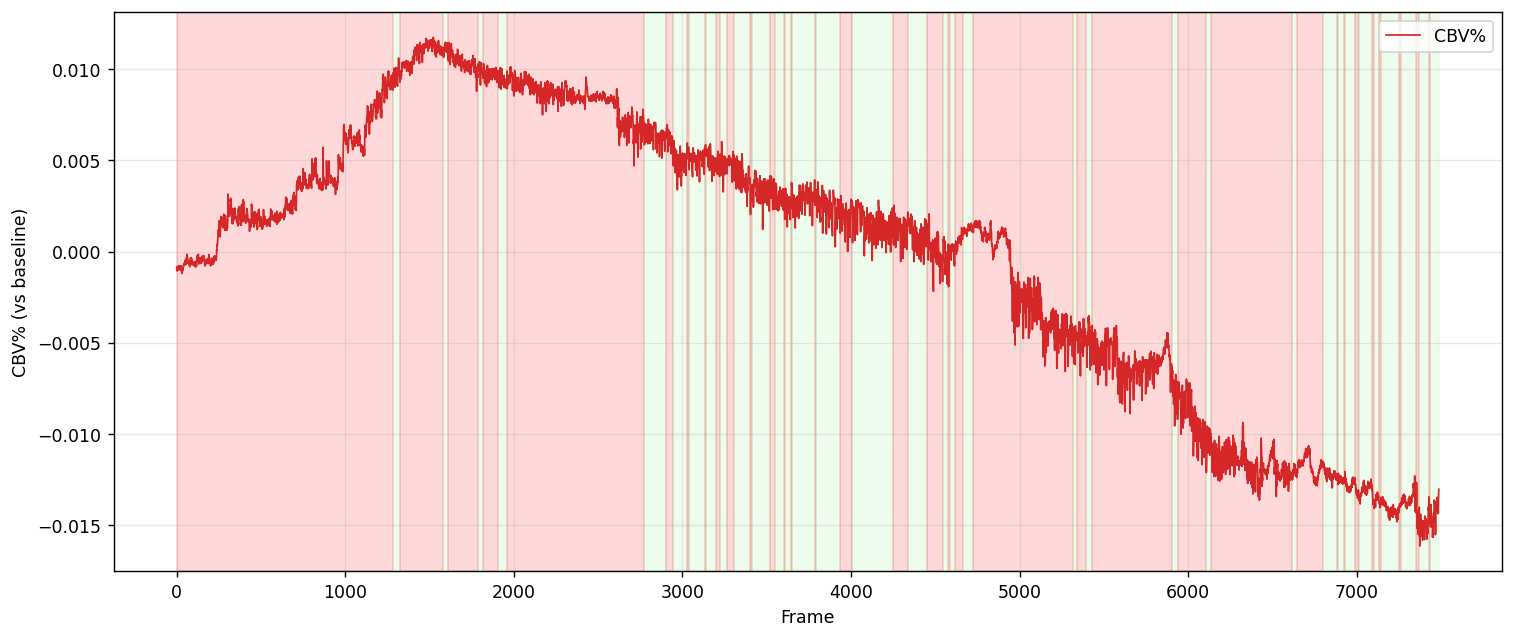

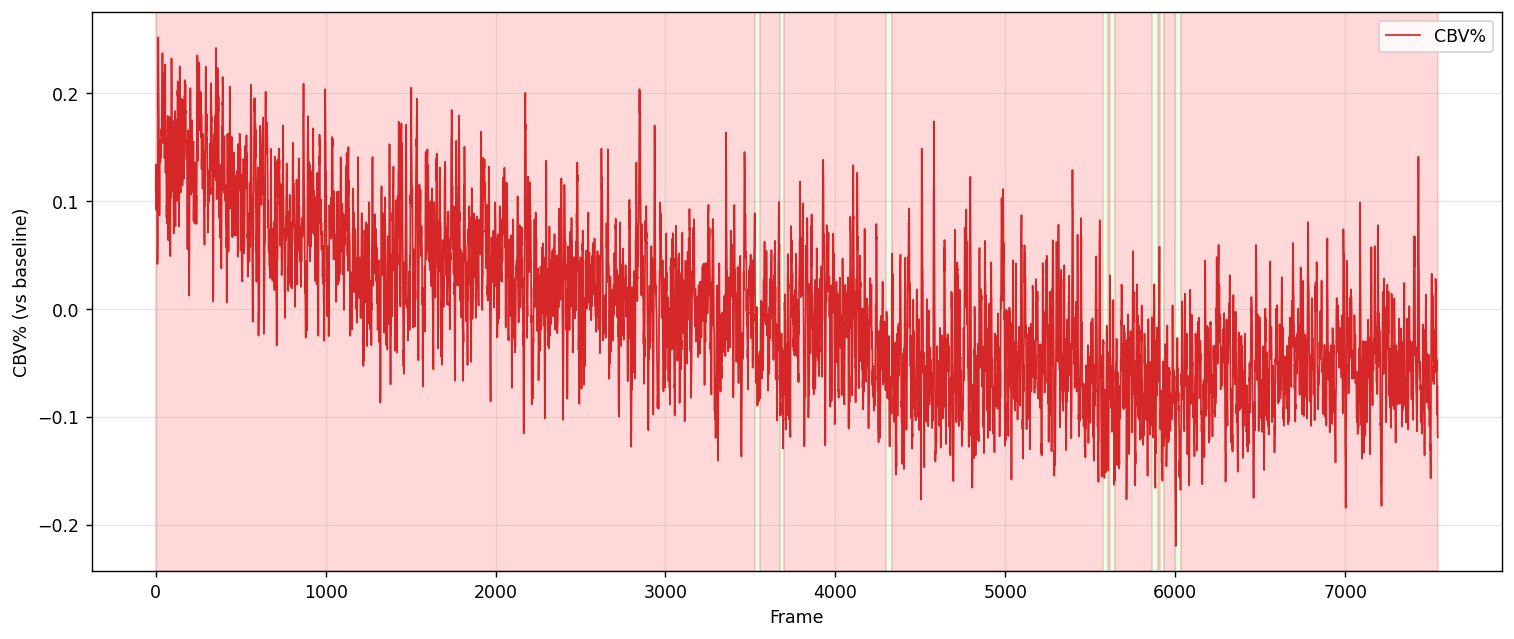

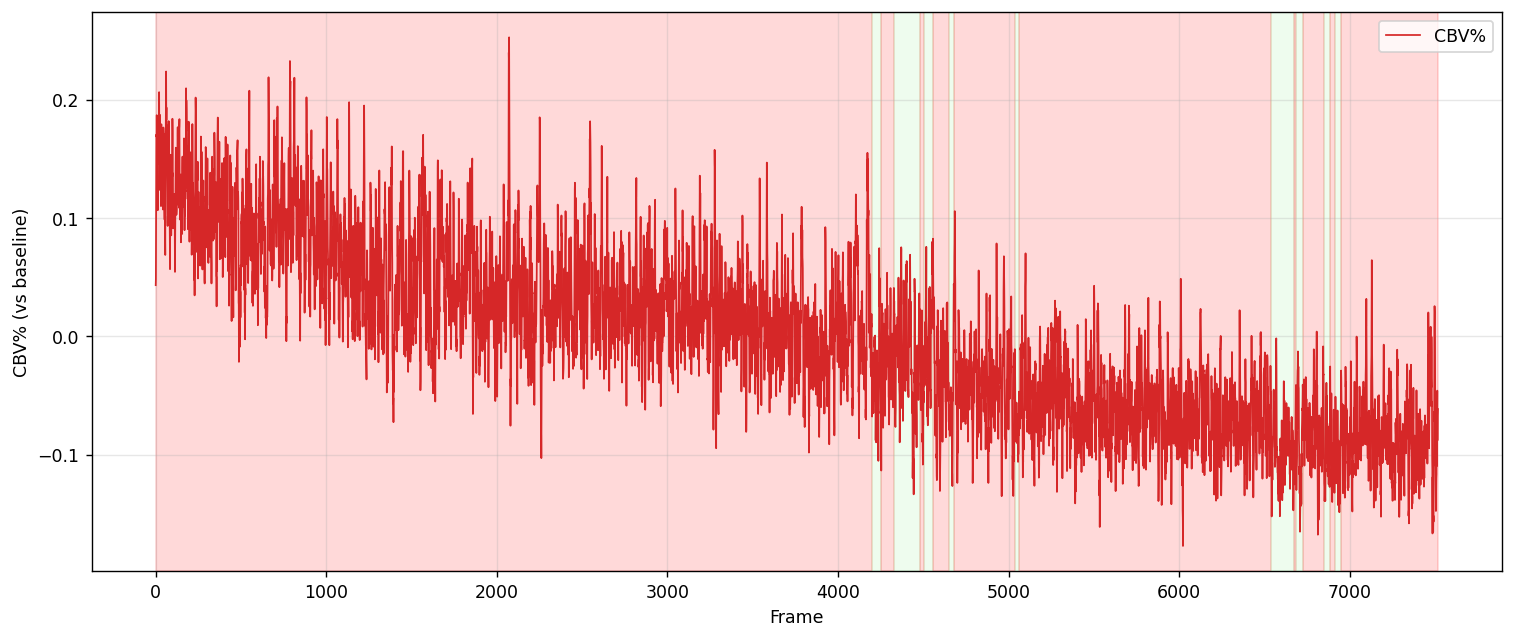

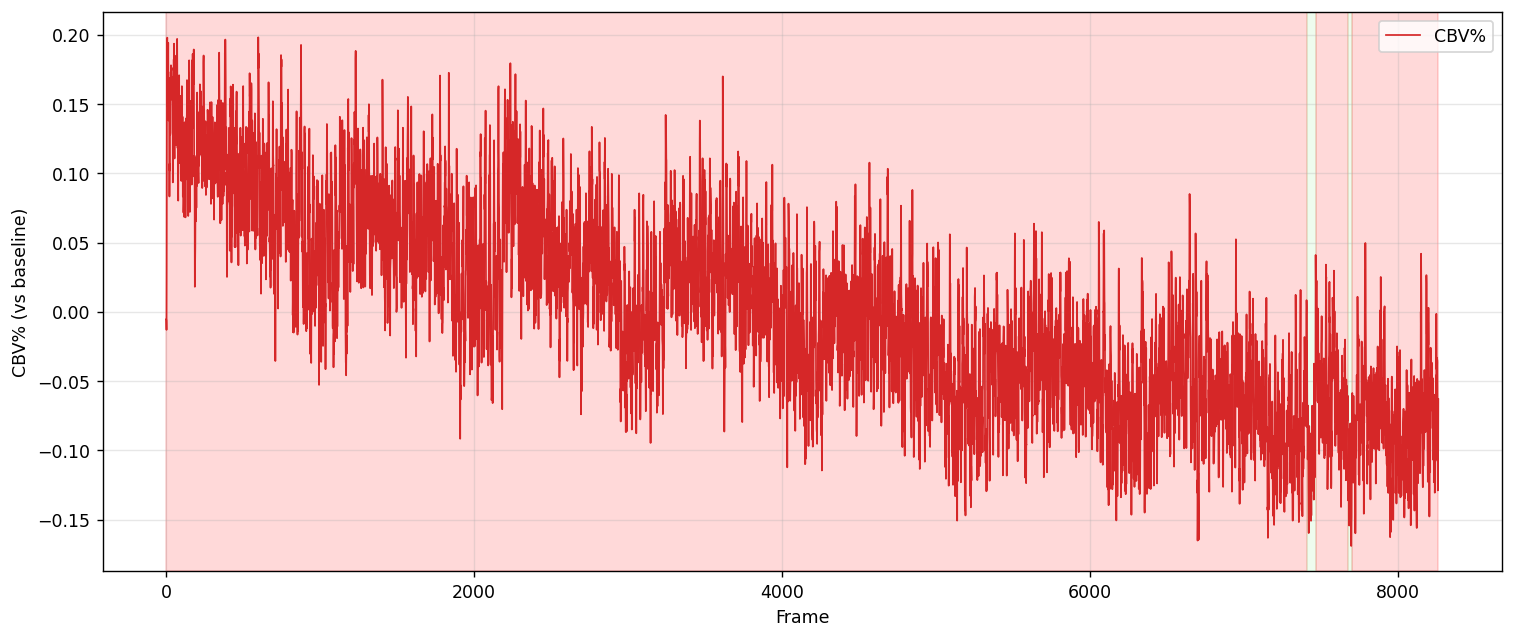

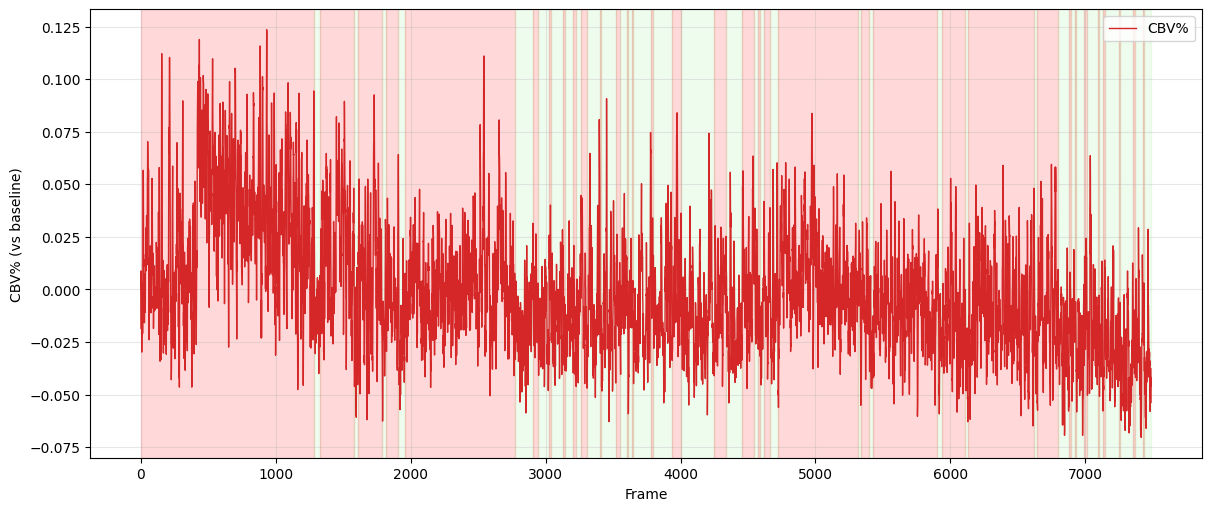

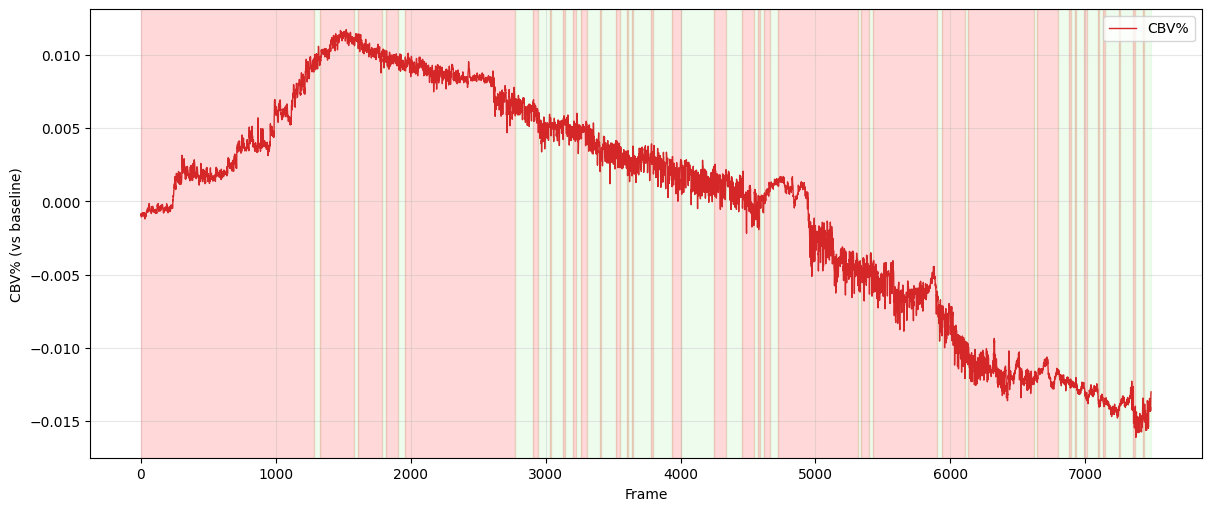

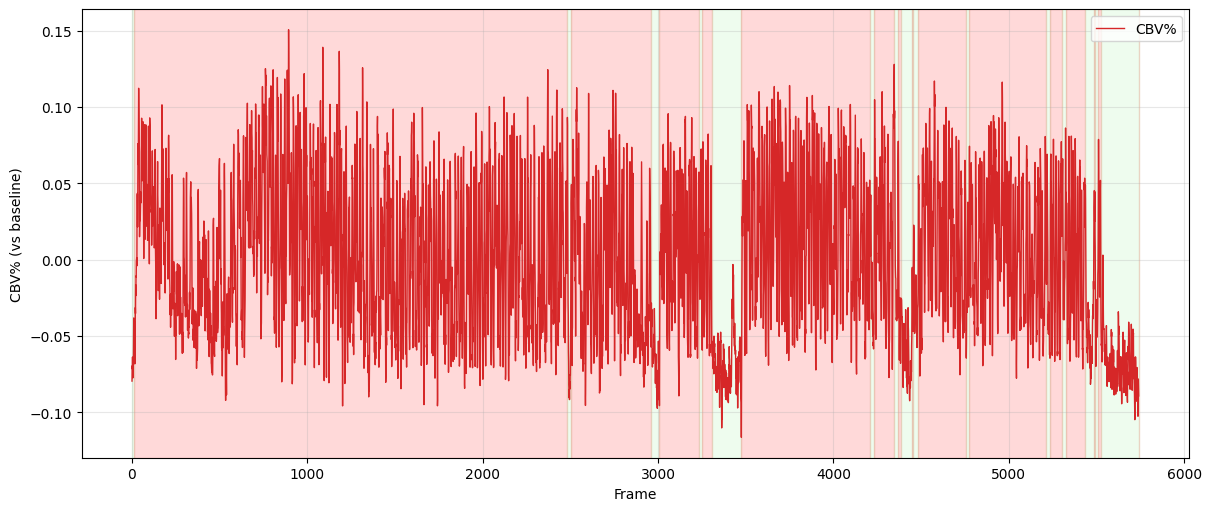

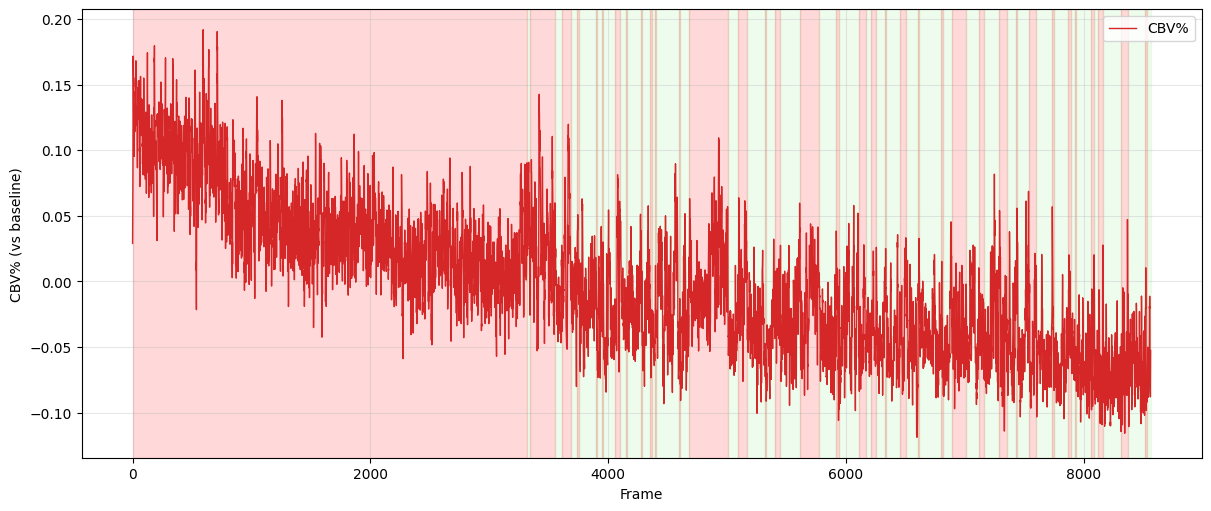

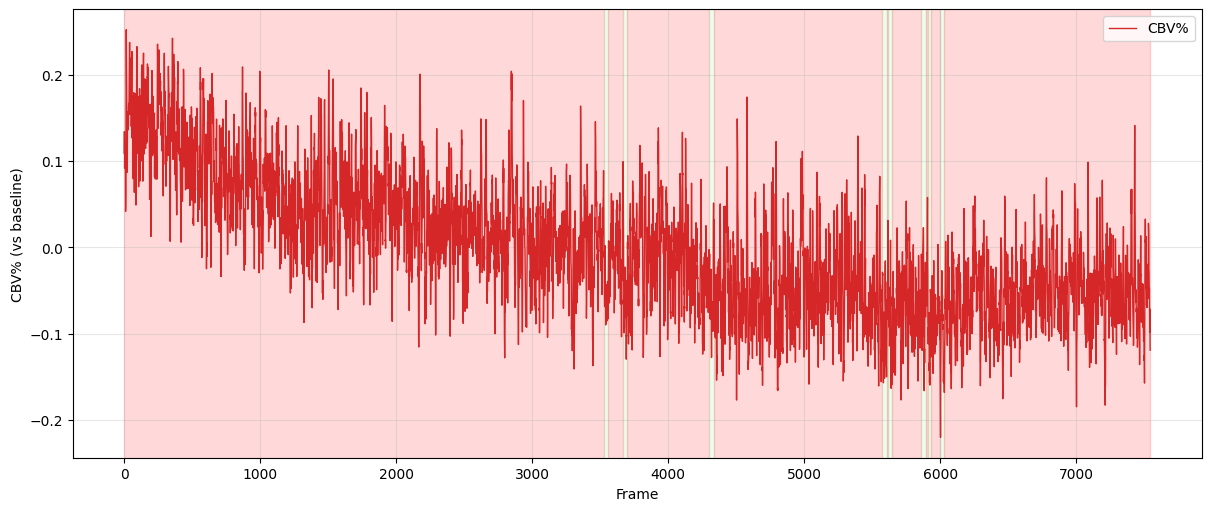

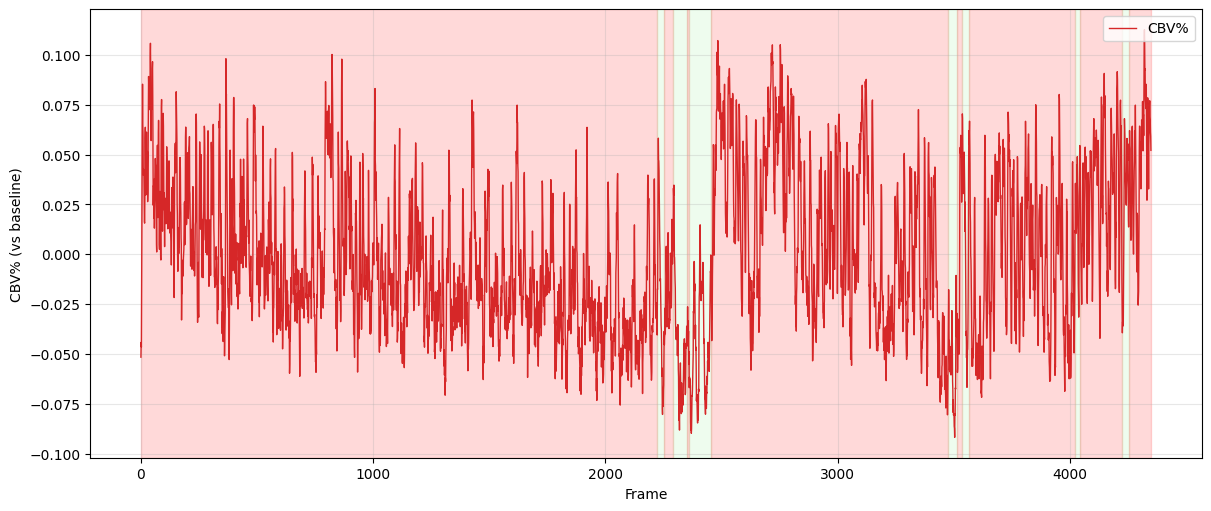

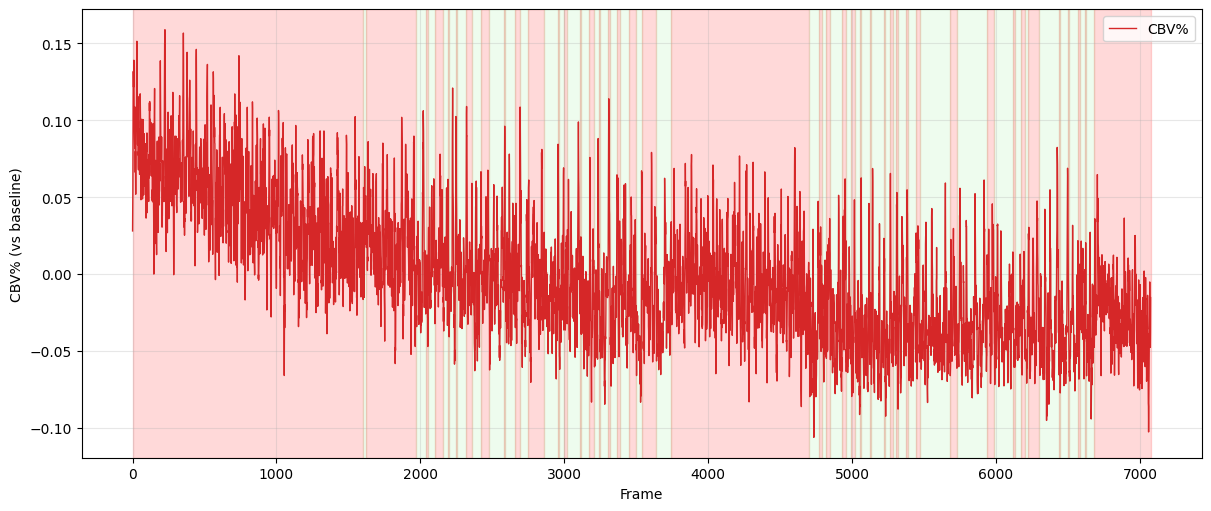

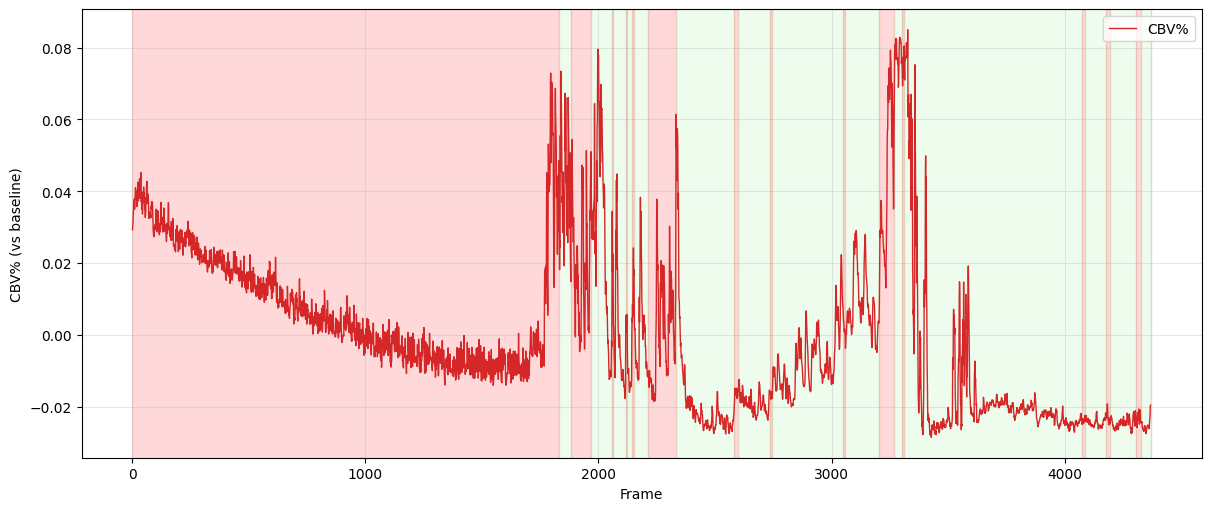

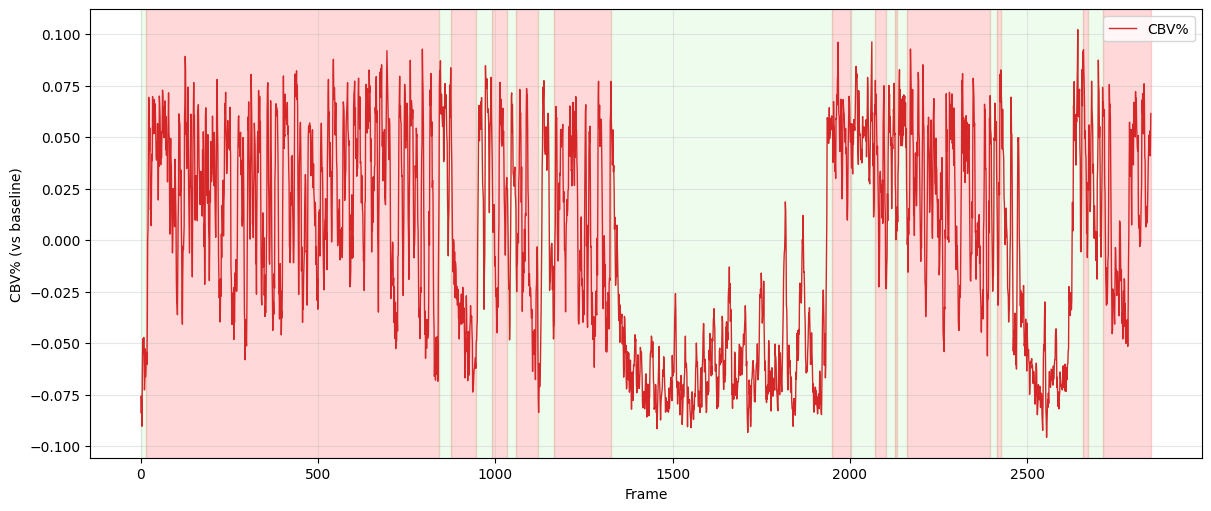

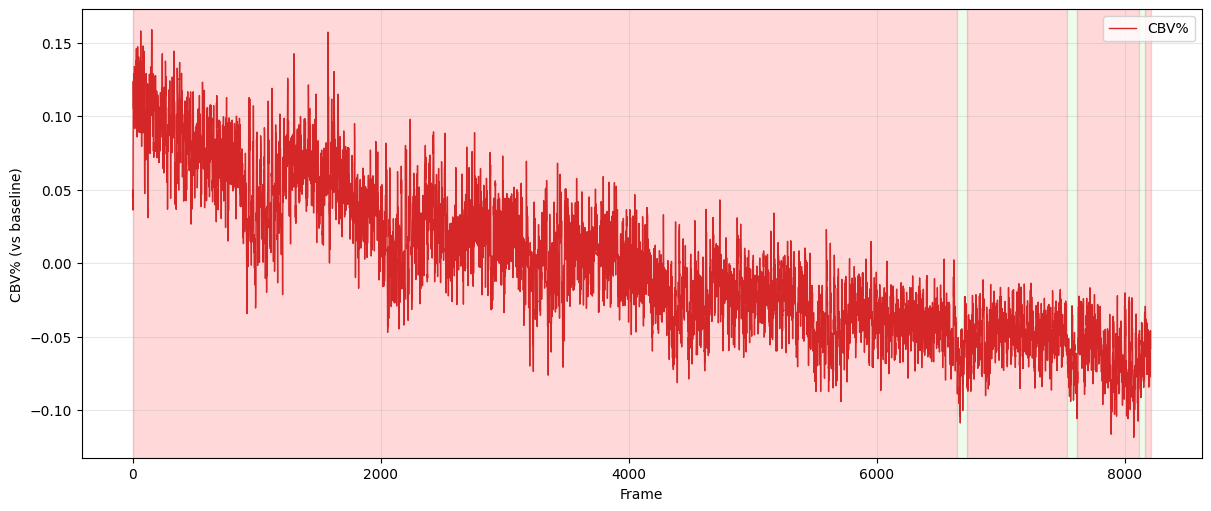

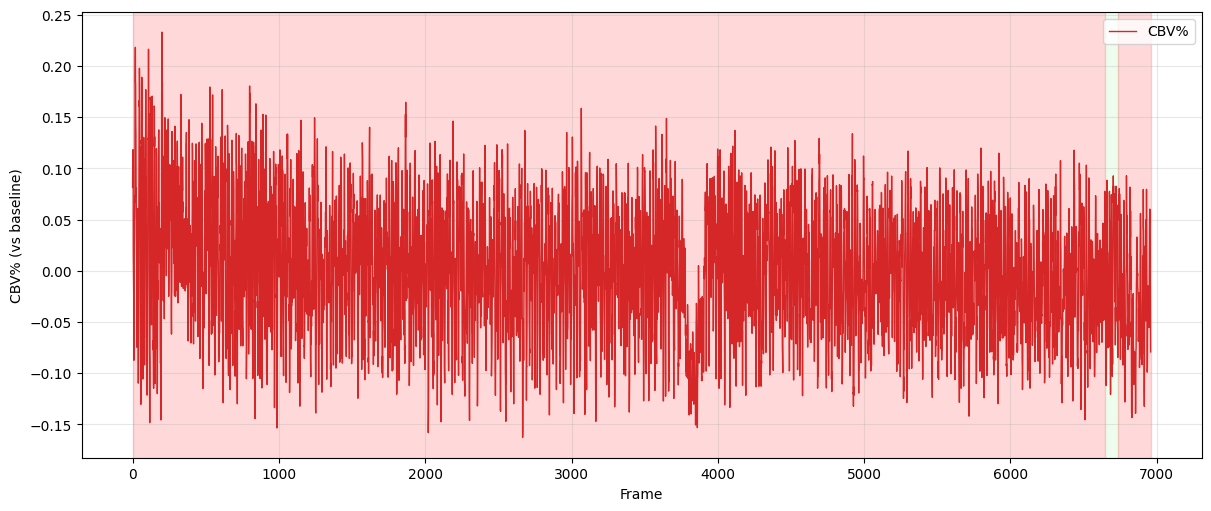

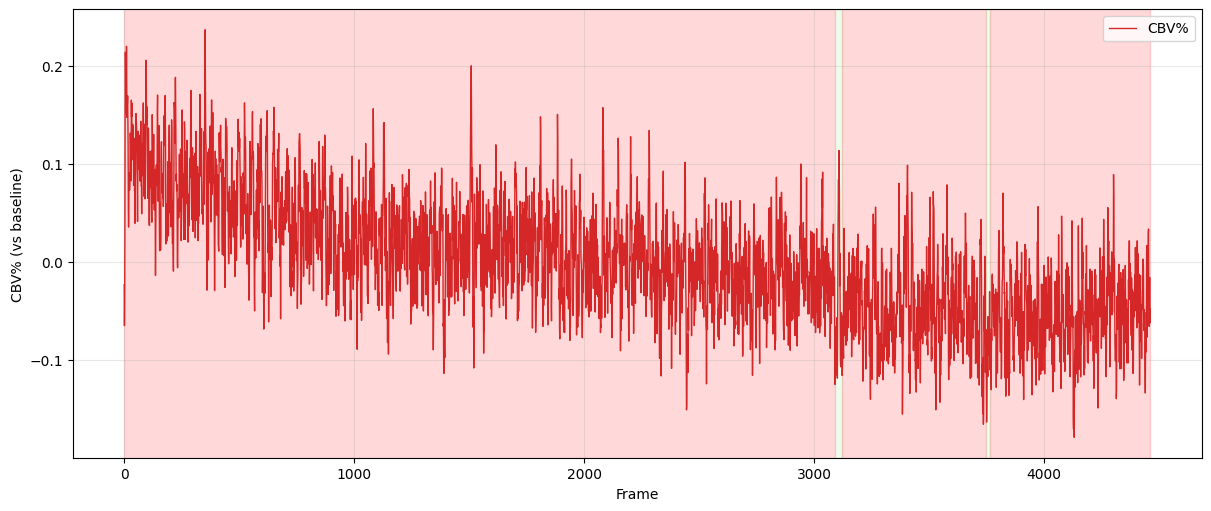

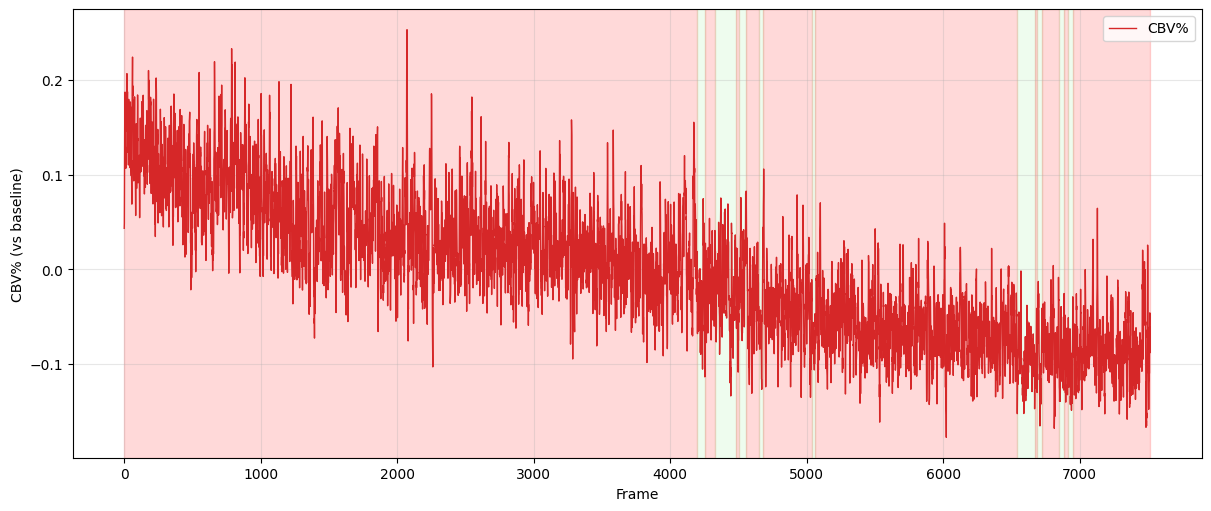

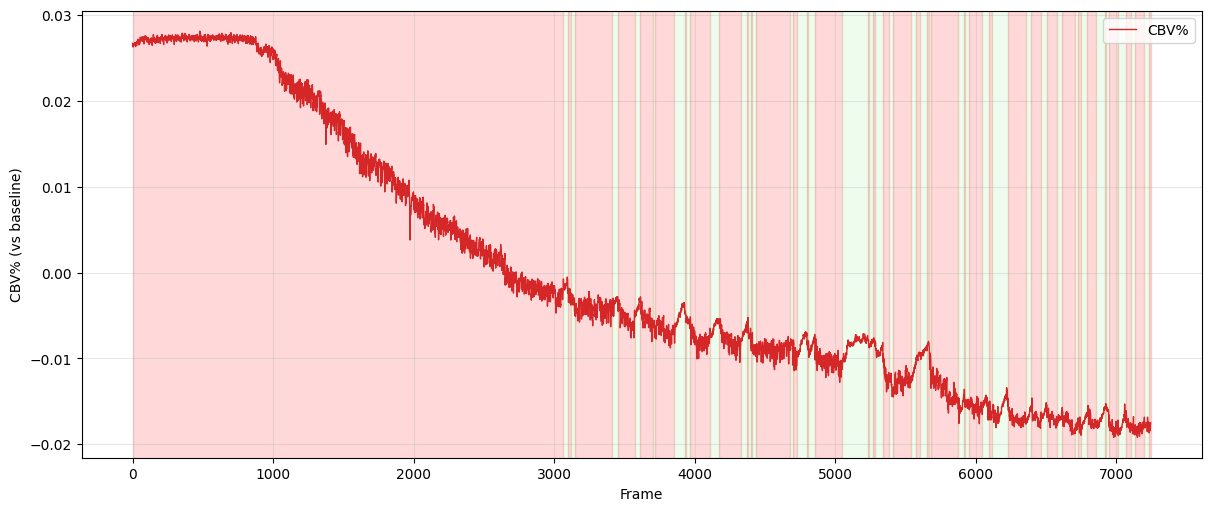

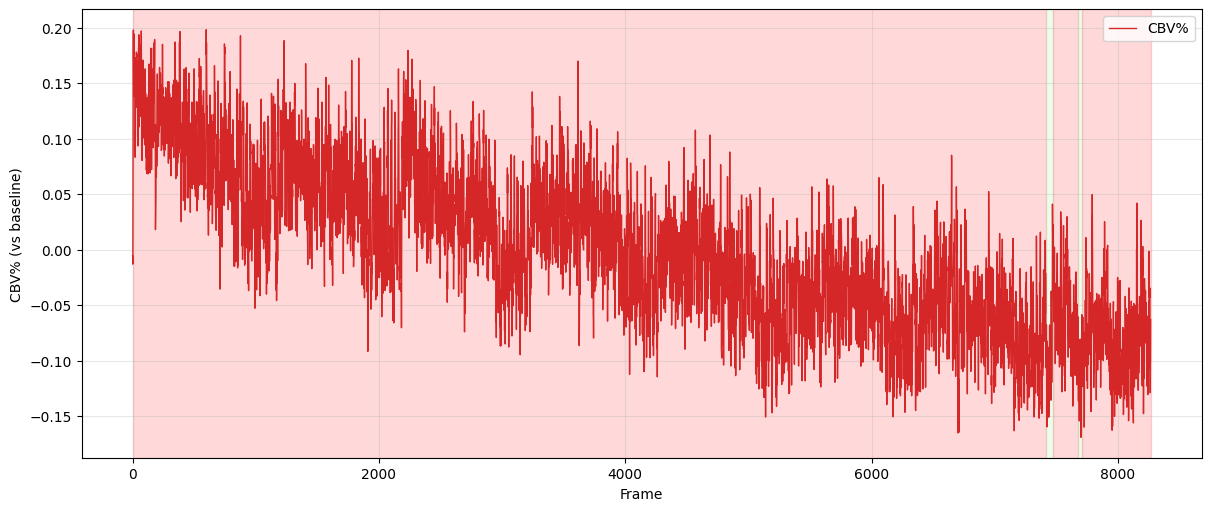

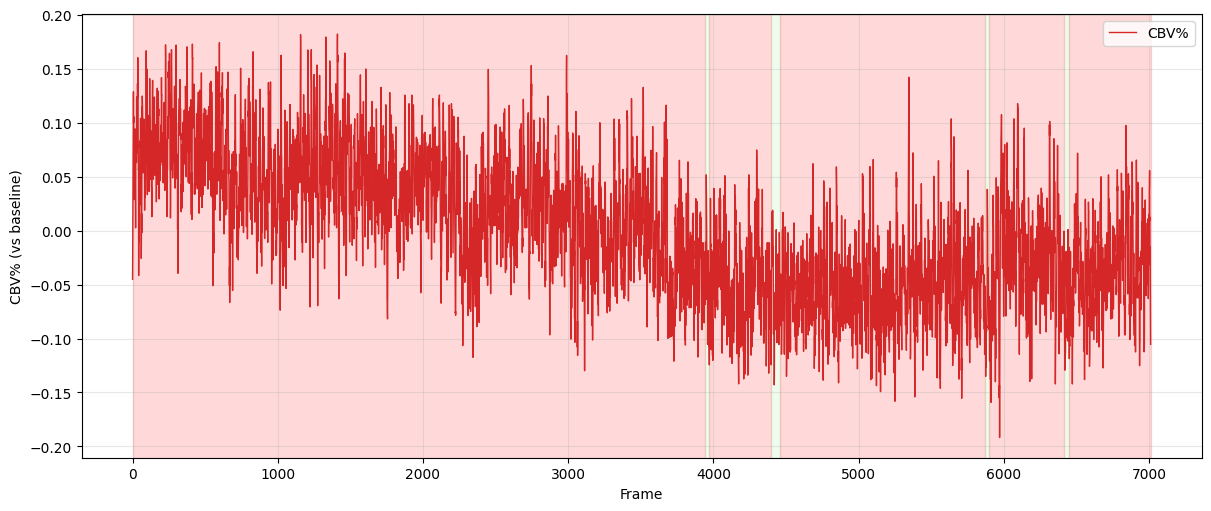

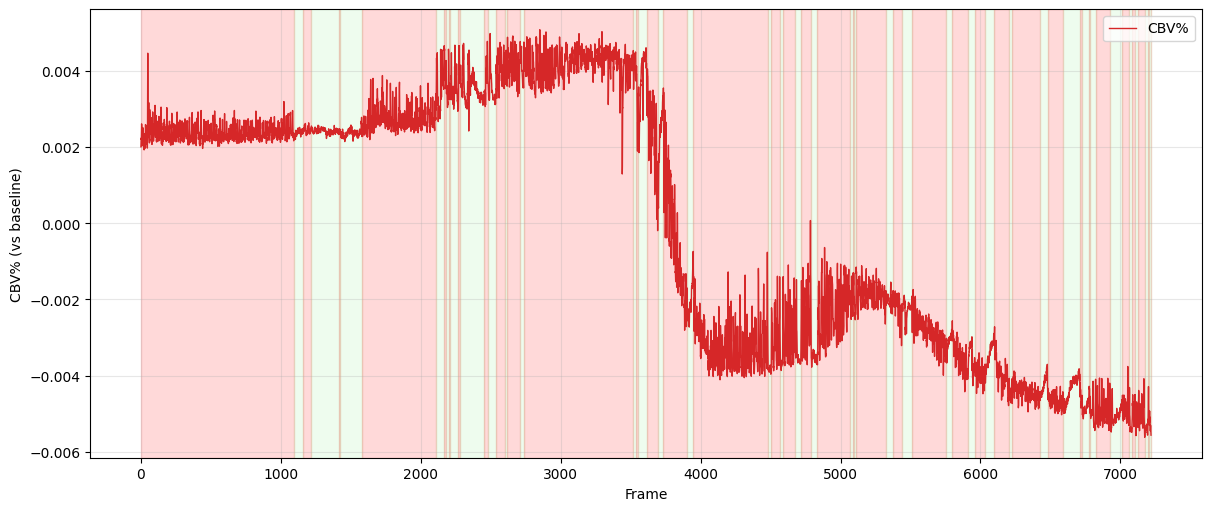

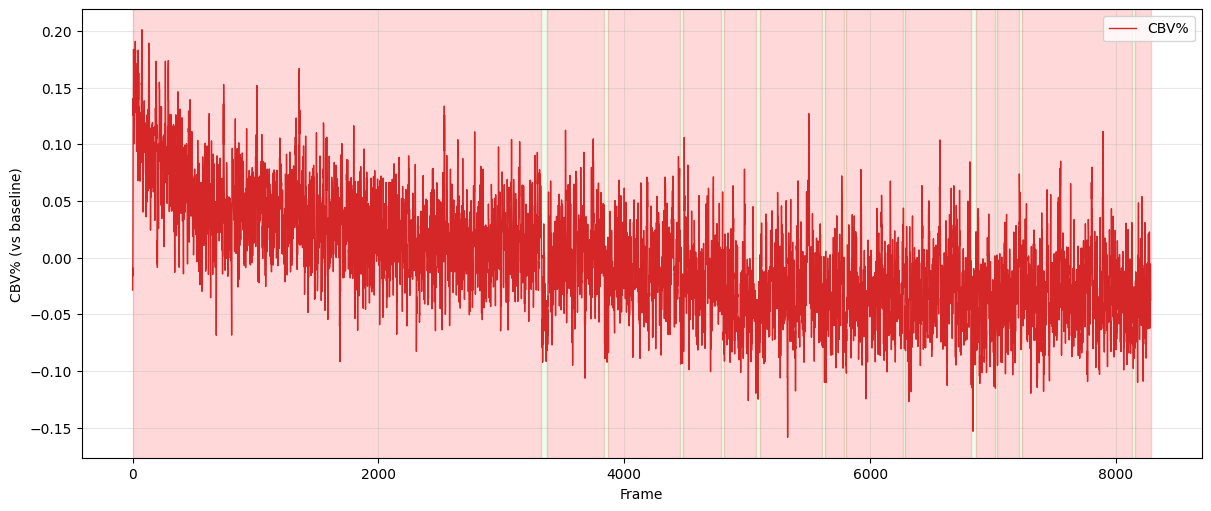

In [205]:
# Mean CBV on top of labels (green shade means pause, red shade means work) of all acquisition in the train set
%matplotlib inline
print("Mean CBV plots for acquisitions: ", train_acqs_unique)
for i in range(len(train_acqs.unique())):
    hf.plot_cbv_mean(train_acqs, train_images, train_labels, train_acqs.unique()[i])  # Appelle ta fonction
plt.show()

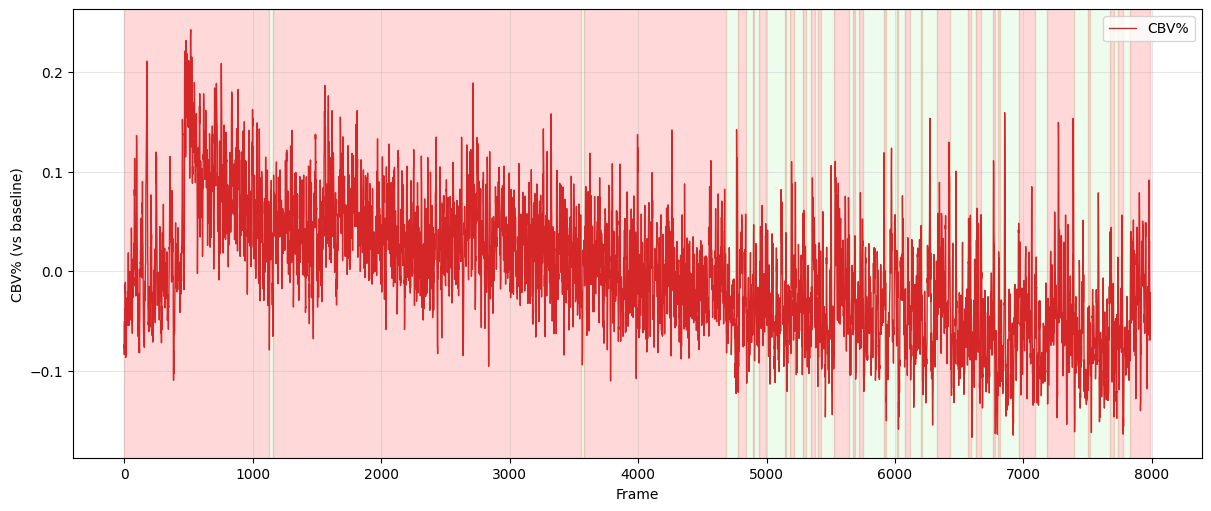

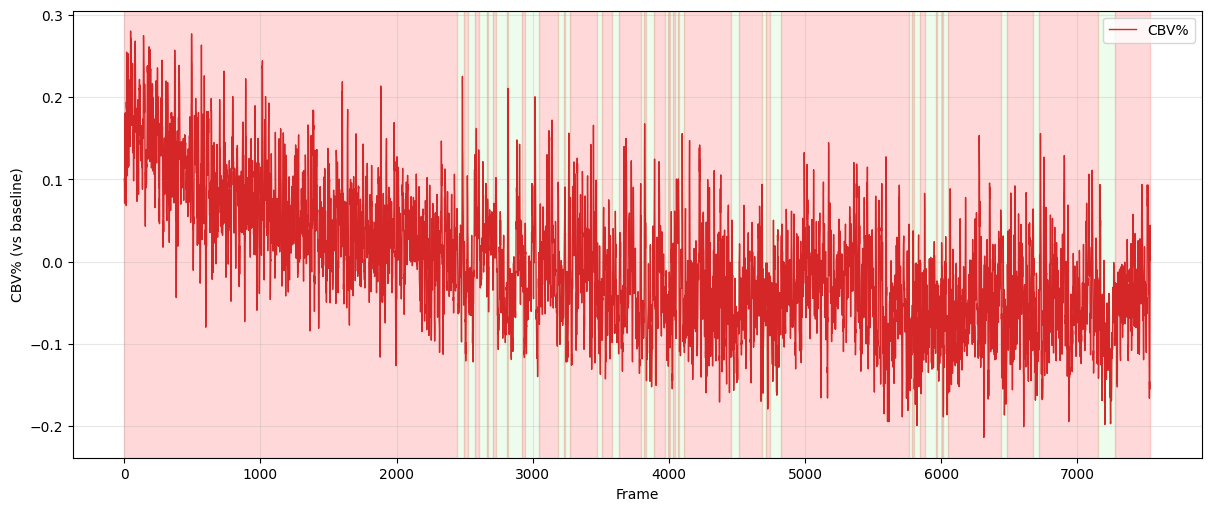

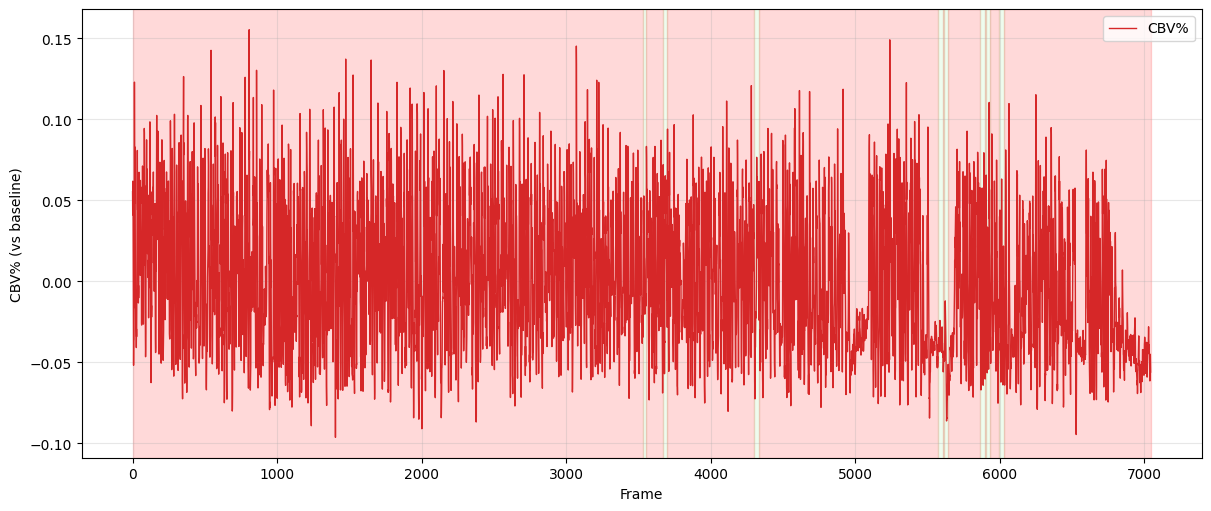

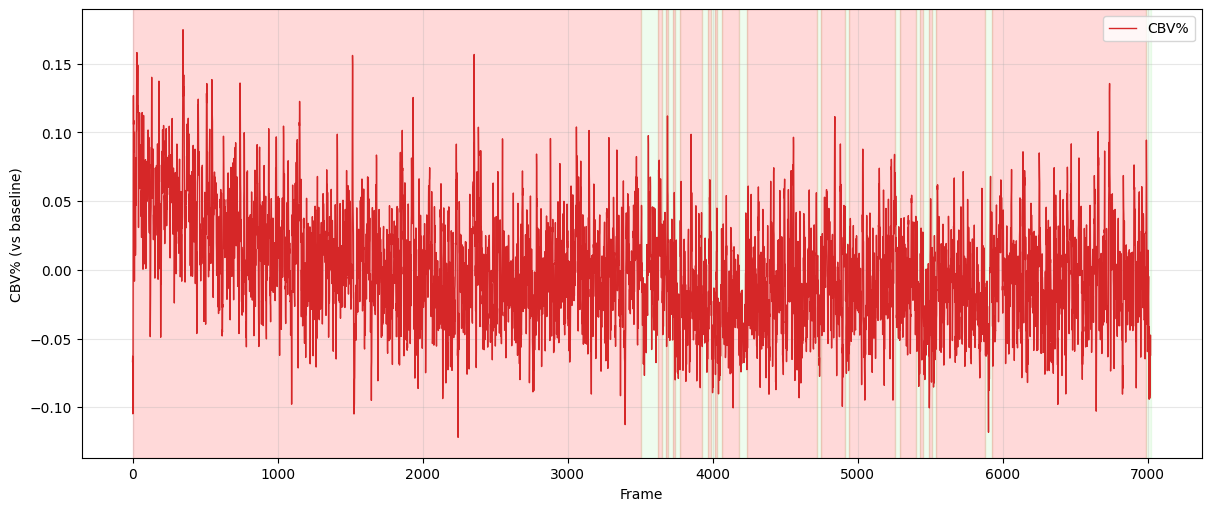

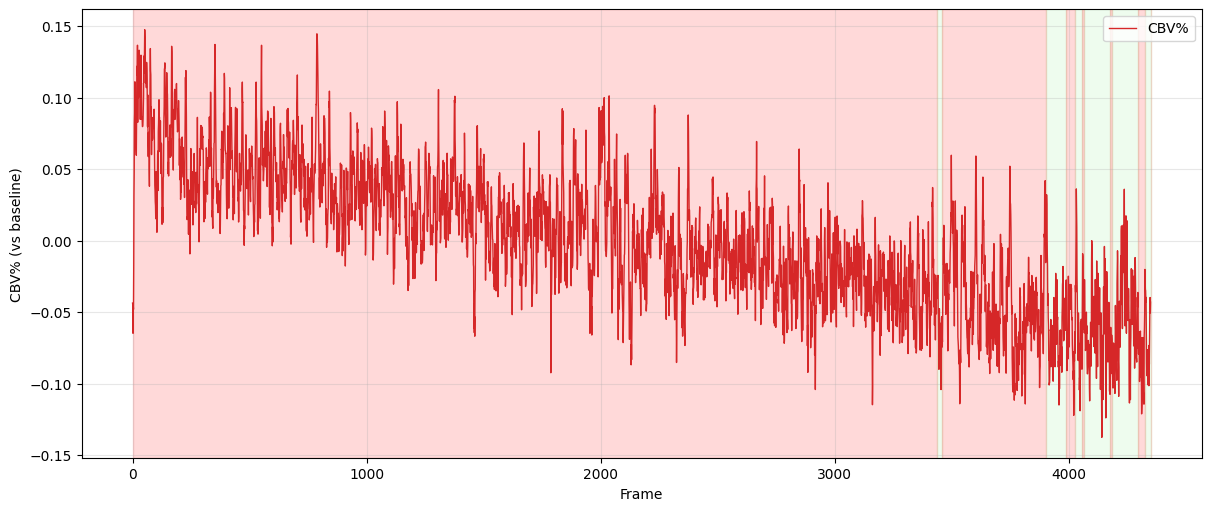

In [ ]:
# Mean CBV on top of labels (green shade means pause, red shade means work) of all acquisition in the test set
%matplotlib inline
print("Mean CBV plots for acquisitions: ", test_acqs_unique)
for i in range(len(test_acqs.unique())):
    hf.plot_cbv_mean(test_acqs, test_images, test_labels, test_acqs.unique()[i])  # Appelle ta fonction
plt.show()

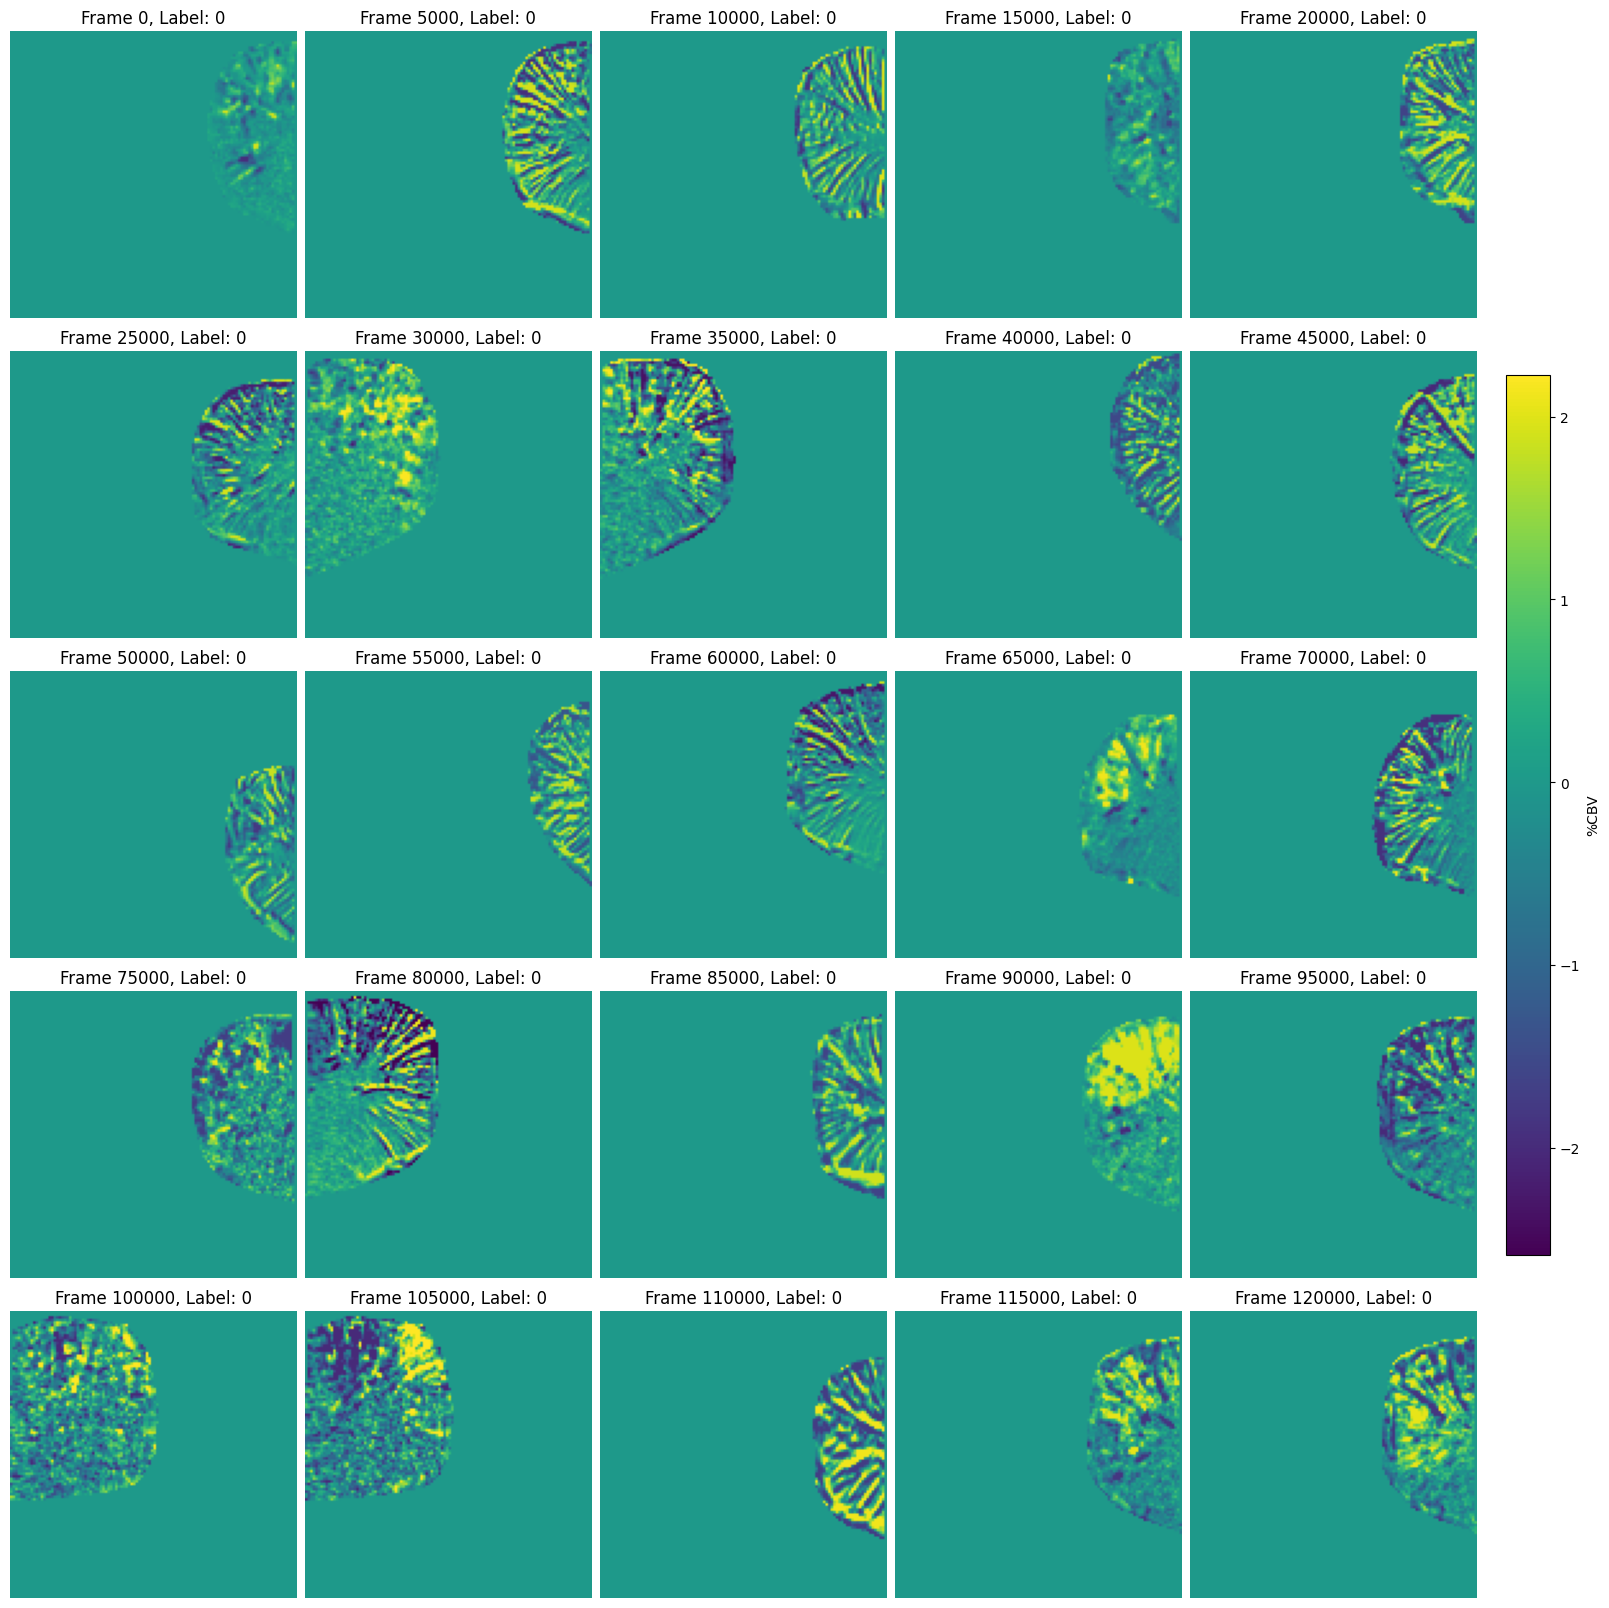

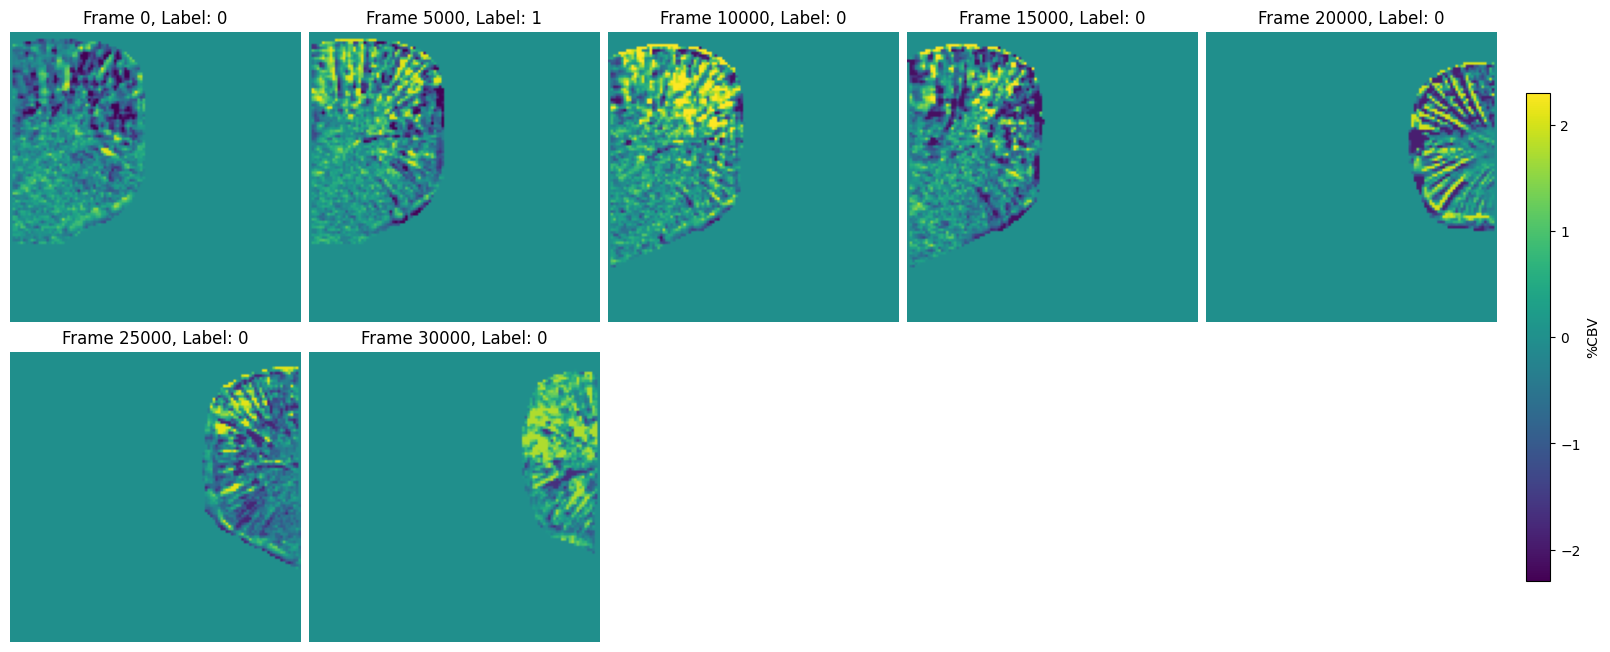

In [ ]:
# Display frames in the train and test sets
%matplotlib inline
hf.plot_cbv_samples (train_images, train_labels, start=0, step=5000, n=64, cmap='viridis', vmin=train_images.min(), vmax=train_images.max(), brain_roi=None)
hf.plot_cbv_samples (test_images, test_labels, start=0, step=5000, n=32, cmap='viridis', vmin=test_images.min(), vmax=test_images.max(), brain_roi=None)

### Dataset creation for the model training

From here we'll be mostly working on the training of the model. Since the training isn't done locally (see train.py), the creation of the dataset is mainly for evalutation/augmentation purposes. 

In [ ]:
# Dataset parameters
window_size = 16
stride = 1  # Overlapping windows for train/test since acquisitions are separated
image_size = 112
batch_size = 16
num_workers = 0  # Adjust based on your system
num_channels = 1
num_labels = 2
num_epochs = 100

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(f"Using device: {device}")

Using device: cuda


The Dataset class creates "patches" of frames (the number of frames being the "window_size") labelling each of them with the last frame's label, the idea is for the model to predict a frame's label using the frames coming before it, like it could in an online setting. The stride represents the gap between each patch creating withing the dataset. So a stride of 1 means the dataset will contain a patch for every frame, wheareas with a stride of 2 it'll be one patch every two frames, and so on.

It also includes data augmentation for the training set, you'll see that the elastic deformation is commented out, that is because it proved to be too agressive, you could resolve this by tweaking its parameters or finding another method of augmentation. 

In [208]:
# Dataset class
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import numpy as np
import math


def gaussian_kernel(size, sigma):
    """Generate a Gaussian kernel."""
    x = torch.arange(-size // 2 + 1, size // 2 + 1, dtype=torch.float32)  # Ensure float32
    y = x
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel
    
class GaussianNoise:
    """Add Gaussian noise to the tensor."""
    def __init__(self, mean=0., std=0.01):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

class FilteredFUSWindowDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor, window_size=8, stride=1, image_size=112, mode='train'):
        """
        Custom Dataset for sliding windows of FUS frames with cropping and normalization.
        For 'train' mode: Balances windows between labels 0 and 1 by downsampling majority class, and applies data augmentation.
        For 'test' mode: Includes all windows, no balancing, no augmentation.
        
        Args:
            data_tensor (torch.Tensor): Shape [N, 1, H, W] (e.g., [6000, 1, 112, 112]).
            labels_tensor (torch.Tensor): Shape [N] with labels (0, 1). Assumes -1 already excluded.
            window_size (int): Number of frames per window (e.g., 8).
            stride (int): Step size for sliding window (e.g., 9 for non-overlapping with small gap).
            image_size (int): Target square size for frames (e.g., 112).
            mode (str): 'train' or 'test' to control balancing and augmentation.
        """
        assert data_tensor.shape[0] == labels_tensor.shape[0], "Data and labels length mismatch"
        assert window_size > 0, "Window size must be positive"
        assert mode in ['train', 'test'], "Mode must be 'train' or 'test'"
        
        self.data = data_tensor
        self.labels = labels_tensor
        self.window_size = window_size
        self.stride = stride
        self.image_size = image_size
        self.mode = mode
        
        self.transform = T.Compose([
            T.Resize((image_size, image_size))  # Ensure square (redundant if already sized)
        ])

        # Build valid indices, skipping excluded zones
        self.valid_indices = []
        for i in range(window_size - 1, len(self.labels), stride):
            if self.labels[i] != -1:  # Assume -1 already filtered out in preprocessing
                self.valid_indices.append(i)

        if len(self.valid_indices) == 0:
            print("Warning: No valid windows found. Check labels or window_size.")
        
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        try:
            end_idx = self.valid_indices[idx]
            start_idx = end_idx - self.window_size + 1
            if start_idx < 0 or end_idx >= len(self.data):
                raise IndexError(f"Invalid window range: [{start_idx}:{end_idx + 1}]")
            
            window = self.data[start_idx:end_idx + 1]  # [T, 1, H, W]
            H, W = window.shape[-2:]
            window = torch.stack([self.transform(frame) for frame in window])  # [T, 1, 112, 112]
            
            # Verify window shape
            if window.shape[0] != self.window_size:
                raise ValueError(f"Expected {self.window_size} frames, got {window.shape[0]}")
                
            # === DATA AUGMENTATION (ONLY IN TRAIN MODE) ===
            if self.mode == 'train':
                # 1. Random Affine (same transformation for all frames)
                affine = T.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2))
                angle, translations, scale, shear = affine.get_params(
                    affine.degrees, affine.translate, affine.scale, affine.shear,
                    (self.image_size, self.image_size)
                )
                for t in range(window.size(0)):
                    window[t] = TF.affine(
                        window[t], angle=angle, translate=translations,
                        scale=scale, shear=shear,
                        interpolation=TF.InterpolationMode.BILINEAR, fill=0
                    )
                '''
                # 2. Elastic deformation (same deformation for all frames)
                alpha = 50.0
                sigma = 5.0
                filter_size = max(5, math.ceil(3 * sigma))
                kernel = gaussian_kernel(filter_size, sigma).unsqueeze(0).unsqueeze(0).to(window.device)
                padding = filter_size // 2

                dx = (torch.rand(1, 1, H, W, device=window.device, dtype=torch.float32) * 2 - 1)
                dy = (torch.rand(1, 1, H, W, device=window.device, dtype=torch.float32) * 2 - 1)

                dx = F.conv2d(dx, kernel, padding=padding) * alpha
                dy = F.conv2d(dy, kernel, padding=padding) * alpha

                dx = dx.squeeze()
                dy = dy.squeeze()

                norm_dx = dx * 2 / W
                norm_dy = dy * 2 / H

                x_coords = torch.linspace(-1, 1, W, device=window.device, dtype=torch.float32)
                y_coords = torch.linspace(-1, 1, H, device=window.device, dtype=torch.float32)
                yy, xx = torch.meshgrid(y_coords, x_coords, indexing='ij')

                grid = torch.stack([xx + norm_dx, yy + norm_dy], dim=-1).unsqueeze(0)  # [1, H, W, 2]
                  
                for t in range(window.size(0)):
                    frame = window[t].unsqueeze(0)  # [1, 1, H, W]
                    # print('frame.shape', frame.shape, 'grid.shape', grid.shape)
                    warped = F.grid_sample(
                        frame.float(), grid.float(), mode='bilinear',
                        padding_mode='zeros', align_corners=True
                    )
                    window[t] = warped.squeeze(0)
                '''
                # 3. Gaussian noise (independent per frame)
                noise = GaussianNoise(std=0.05)
                window = noise(window)
            
            
            label = self.labels[end_idx]
            return window, label
        except Exception as e:
            print(f"Error in __getitem__ at idx {idx}, end_idx {end_idx}: {e}")
            raise

In [210]:
# Create datasets
train_dataset = FilteredFUSWindowDataset(
    data_tensor=train_images,
    labels_tensor=train_labels,
    window_size=window_size,
    stride=stride,
    image_size=image_size,
    mode='train'
)

test_dataset = FilteredFUSWindowDataset(
    data_tensor=test_images,
    labels_tensor=test_labels,
    window_size=window_size,
    stride=stride,
    image_size=image_size,
    mode='test'
)

print(f"Train dataset size: {len(train_dataset)} windows")
print(f"Test dataset size: {len(test_dataset)} windows")

Train dataset size: 120635 windows
Test dataset size: 33927 windows


Here is the function to compute the weights of the loss function. It's either that or balance out the dataset, which I've generally found it worked better. 

In [211]:
# Class weights
def compute_label_distribution(dataset):
    """
    Compute label counts from the dataset's valid windows.
    """
    if len(dataset.valid_indices) == 0:
        return {label: 0 for label in range(num_labels)}
    
    valid_labels = dataset.labels[dataset.valid_indices].numpy()  # Convert to numpy for unique
    unique, counts = np.unique(valid_labels, return_counts=True)
    dist = dict(zip(unique, counts))
    
    # Fill missing labels with 0
    for label in range(num_labels):
        if label not in dist:
            dist[label] = 0
    
    return dist

# Compute distributions
train_dist = compute_label_distribution(train_dataset)
test_dist = compute_label_distribution(test_dataset)

# Print distributions
print("Train Dataset Label Distribution:")
for label, count in train_dist.items():
    print(f"Label {label}: {count} ({count / len(train_dataset) * 100:.2f}%)" if len(train_dataset) > 0 else f"Label {label}: 0 (0.00%)")

print("\nTest Dataset Label Distribution:")
for label, count in test_dist.items():
    print(f"Label {label}: {count} ({count / len(test_dataset) * 100:.2f}%)" if len(test_dataset) > 0 else f"Label {label}: 0 (0.00%)")

# Compute class weights based on train distribution (inverse frequency)
total_train_samples = len(train_dataset)
class_weights = []
for label in range(num_labels):
    count = train_dist.get(label, 0)
    if count > 0:
        weight = total_train_samples / (num_labels * count)
    else:
        weight = 0.0  # Or handle as needed (e.g., 1.0 if no samples)
    class_weights.append(weight)

weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
print("\nClass Weights Tensor for CrossEntropyLoss (based on train dist):")
print(weights_tensor)

Train Dataset Label Distribution:
Label 0: 100109 (82.99%)
Label 1: 20526 (17.01%)

Test Dataset Label Distribution:
Label 0: 29078 (85.71%)
Label 1: 4849 (14.29%)

Class Weights Tensor for CrossEntropyLoss (based on train dist):
tensor([0.6025, 2.9386])


In [212]:
# Create DataLoaders
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True  # Avoid partial batch issues
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # No shuffling for test
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False  # Keep all test samples
)

print(f"Train DataLoader: {len(train_dataloader)} batches of size {batch_size}")
print(f"Test DataLoader: {len(test_dataloader)} batches of size {batch_size}")

Train DataLoader: 7539 batches of size 16
Test DataLoader: 2121 batches of size 16


So here is the model I have been training, videomae-small-finetuned-kinetics. It's a video classifier model based on VideoMAE which is a video adaptation of masked auto-encoder models (https://arxiv.org/abs/2203.12602). I've gone for the small version because the base version had too many parameters in my experience and would quickly overfit on the data, but it could still pertinent to try other version.

The model's parameters are adapted to our dataset and classifying task depending on the dataset parameters. We also add dropout layers to limit overfitting.

One thing of note is that this model is pre-trained to the "kinetics" (https://github.com/cvdfoundation/kinetics-dataset). Videos of human actions are structurally very different compared to fUS imaging. One possible route would be to pre-train this model (or whatever classifier model we end up using) to a different dataset of fUS imaging. This could significantly boost the accuracy, as it did in other Ultrasound classifying studies. 

In [ ]:
# Load and configurate VideoMAE-small
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from transformers import VideoMAEForVideoClassification, VideoMAEConfig

model_name = "MCG-NJU/videomae-small-finetuned-kinetics"

# Custom config for your FUS data
config = VideoMAEConfig.from_pretrained(model_name)
config.num_channels = num_channels  # Grayscale FUS data
config.image_size = image_size  # Your frame size
config.num_frames = window_size   # Your window size
config.num_labels = num_labels   # Work (0) vs Pause (1)
config.attention_dropout = 0.1  # Add dropout to attention weights
config.hidden_dropout = 0.1     # Add dropout in transformer blocks
config.classifier_dropout = 0.5 # Add dropout before classifier

# Initialize model with custom config
model = VideoMAEForVideoClassification(config)

# Load pre-trained weights and adapt for 1 channel
pretrained_model = VideoMAEForVideoClassification.from_pretrained(model_name)
pretrained_dict = pretrained_model.state_dict()

# Adapt patch embedding weights: Average over RGB channels
pretrained_embed_weight = pretrained_dict['videomae.embeddings.patch_embeddings.projection.weight']  # Smaller: [384, 3, 2, 16, 16]
new_embed_weight = pretrained_embed_weight.mean(dim=1, keepdim=True)  # [384, 1, 2, 16, 16]
pretrained_dict['videomae.embeddings.patch_embeddings.projection.weight'] = new_embed_weight


# Remove classifier weights (reinitialized for 2 classes)
del pretrained_dict['classifier.weight']
del pretrained_dict['classifier.bias']

# Load adapted weights
model.load_state_dict(pretrained_dict, strict=False)
model.to(device)
print("Small VideoMAE loaded with adapted weights")

Small VideoMAE loaded with adapted weights


### Model evaluation

As stated before, the actual training of the model is in the .py scripts that are ran on the institute's cluster (locally it'd crash the computer). So after training, we load the model's values and test it out;

In [65]:
model.load_state_dict(torch.load(r"C:\Users\leo.sperber\FUSclass\Results V1\masked test\fus_videomae_small_16_nohp_balanced_zscore_masked_STABLE_balance.pth"))

<All keys matched successfully>

A few general evaluation metrics of classifier model, could be pertinent to add other to make the evaluation more robust.

100%|██████████| 1490/1490 [03:51<00:00,  6.42it/s]



FINAL TEST RESULTS
Accuracy         : 0.8848
F1-Score         : 0.7195
Precision        : 0.6212
Recall (Sensitivity) : 0.8548
ROC-AUC          : 0.9387
PR-AUC           : 0.7738


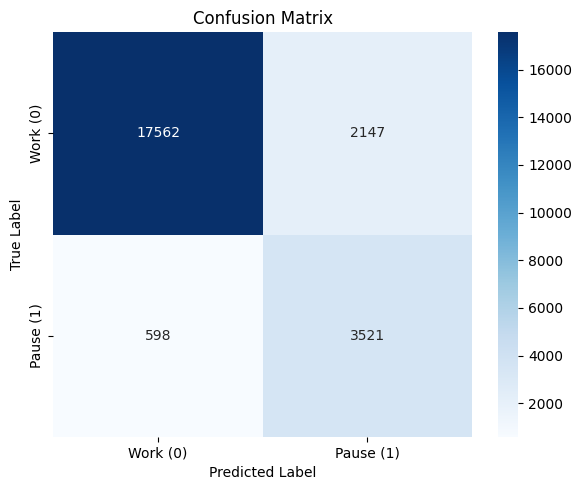

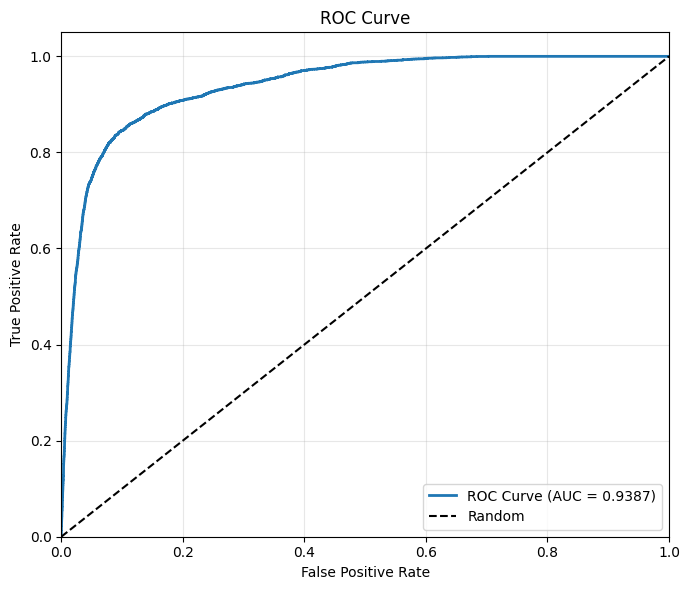

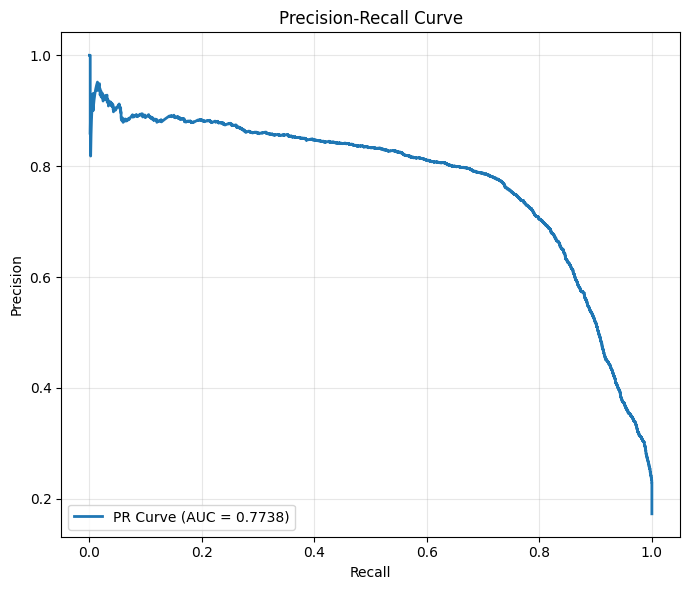

All plots saved: confusion_matrix.png, roc_curve.png, pr_curve.png


In [ ]:
# F1 score, confusion matrix, ROC curve, precision-recall curve
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import VideoMAEForVideoClassification, VideoMAEConfig
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import os


# ==================== EVALUATION ====================
all_preds = []
all_labels = []
all_probs = []  # for ROC, PR curves

with torch.no_grad():
    for batch_windows, batch_labels in tqdm(test_dataloader):
        inputs = batch_windows.to(device).float()
        labels = batch_labels.to(device, dtype=torch.long)
        outputs = model(pixel_values=inputs).logits
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_probs.extend(probabilities[:, 1].cpu().numpy())   # prob of class 1 (Pause)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)

# ==================== METRICS ====================
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)  # sensitivity
roc_auc = roc_auc_score(y_true, y_prob)
pr_auc = average_precision_score(y_true, y_prob)

print("\n" + "="*50)
print("FINAL TEST RESULTS")
print("="*50)
print(f"Accuracy         : {acc:.4f}")
print(f"F1-Score         : {f1:.4f}")
print(f"Precision        : {precision:.4f}")
print(f"Recall (Sensitivity) : {recall:.4f}")
print(f"ROC-AUC          : {roc_auc:.4f}")
print(f"PR-AUC           : {pr_auc:.4f}")
print("="*50)

# ==================== PLOTS ====================

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Work (0)', 'Pause (1)'],
            yticklabels=['Work (0)', 'Pause (1)'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_prob)
plt.figure(figsize=(7, 6))
plt.plot(rec, prec, label=f'PR Curve (AUC = {pr_auc:.4f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

One important aspect of the model is its capability to quickly recognize a state transition, when the monkey goes from a pause to working or from working to a pause. So here we isolate windows of frames around a transition point and plot the mean prediction of the model across all the windows it classified.>

Found 37 valid transitions.
New transition windows tensor shape: torch.Size([37, 116, 1, 112, 112])


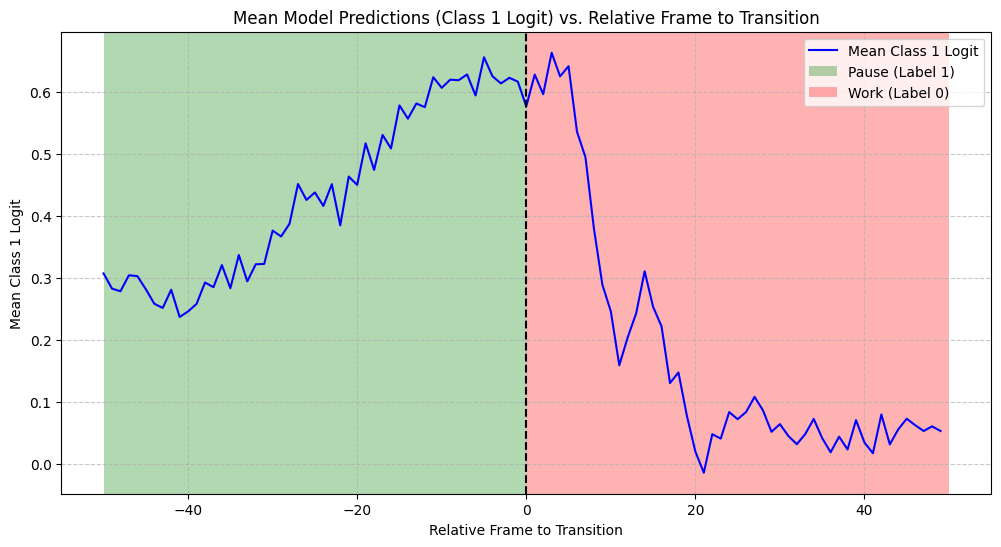

Mean logits statistics:
Mean logit (pause, -50 to 0): 0.4333
Mean logit (work, 0 to +50): 0.1721


In [ ]:
# Pause to work window and plot
import torch
import numpy as np

# Extract tensors from doppler_test_dataset
data_tensor = test_images # Shape: (N, 1, 112, 112)
labels_tensor = test_labels  # Shape: (N,)

# Parameters
min_state_length = 20
before_frames = 66
after_frames = 50
window_length = before_frames + after_frames

# Convert labels to NumPy for easier indexing
labels_np = labels_tensor.cpu().numpy()

# Find potential transition points: from 1 (pause) to 0 (work)
transitions = []
N = len(labels_np)
for i in range(1, N):
    if labels_np[i-1] == 1 and labels_np[i] == 0:
        # Check before: at least 50 consecutive 1's before i (i-51 to i-1 all 1)
        if i - min_state_length - 1 >= 0 and np.all(labels_np[i - min_state_length - 1:i - 1] == 1):
            # Check after: at least 50 consecutive 0's after i (i to i+49 all 0)
            if i + min_state_length <= N and np.all(labels_np[i:i + min_state_length] == 0):
                transitions.append(i)

print(f"Found {len(transitions)} valid transitions.")

# Create windows for each transition
windows = []
for trans_point in transitions:
    start_idx = trans_point - before_frames
    end_idx = trans_point + after_frames
    if start_idx >= 0 and end_idx <= N:
        window = data_tensor[start_idx:end_idx]
        windows.append(window)
    else:
        print(f"Skipping transition at {trans_point}: Insufficient frames around it.")

if windows:
    new_windows_tensor = torch.stack(windows)  # Shape: (K, window_length, 1, 112, 112)
    print(f"New transition windows tensor shape: {new_windows_tensor.shape}")
else:
    new_windows_tensor = torch.empty(0, window_length, 1, 112, 112)
    print("No valid transition windows found.")

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

model.eval()

# Assume model, device, new_window_tensor, WINDOW_SIZE, and other variables are defined
# new_window_tensor: [8, 72, 1, 112, 112] (8 transitions, each with 72 frames)

# Parameters
transition_point = 66 # Transition at frame 50 (0-based: frame 49 = last pause, 50 = first work)
relative_start = -50  # Relative to transition
relative_end = 50
relative_range = range(relative_start, relative_end)  # -50 to +50
num_transitions = new_windows_tensor.shape[0]  # 8

# Collect logits for class 1 across all transitions and relative positions
all_logits_class1 = np.zeros((num_transitions, len(relative_range)))  # [8, 101] for -50 to +50

with torch.no_grad():
    for trans_idx in range(num_transitions):
        transition_window = new_windows_tensor[trans_idx:trans_idx+1].to(device)  # [1, 72, 1, 112, 112]
        
        # Slide sub-windows of WINDOW_SIZE=16 over the 72-frame window
        # For each relative k, get sub-window ending at transition_point + k
        for k_idx, k in enumerate(relative_range):
            end_frame = transition_point + k
            start_frame = end_frame - window_size
            
            if start_frame < 0 or end_frame >= transition_window.shape[1]:
                print(f"Skipping invalid sub-window for trans {trans_idx}, relative {k}")
                print(f"  start_frame: {start_frame}, end_frame: {end_frame}")
                print(f"  window length: {transition_window.shape[1]}")
                continue
            
            sub_window = transition_window[:, start_frame:end_frame, :, :, :]  # [1, 16, 1, 112, 112]
            sub_window = sub_window.float()
            # Get model outputs
            outputs = model(pixel_values=sub_window).logits  # [1, 2]
            
            # Extract logit for class 1
            logit_class1 = outputs[0, 1].cpu().item()  # Raw score for class 1
            
            all_logits_class1[trans_idx, k_idx] = logit_class1

# Compute mean logits across transitions for each relative position
mean_logits_class1 = np.mean(all_logits_class1, axis=0)  # [101,]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the mean logits for class 1
plt.plot(relative_range, mean_logits_class1, color='blue', label='Mean Class 1 Logit', linewidth=1.5)

# Create background shading for labels
# Pause (-50 to 0): green, Work (0 to +50): red
plt.axvspan(relative_start, 0, facecolor='green', alpha=0.3, label='Pause (Label 1)')
plt.axvspan(0, relative_end, facecolor='red', alpha=0.3, label='Work (Label 0)')

# Customize the plot
plt.xlabel('Relative Frame to Transition')
plt.ylabel('Mean Class 1 Logit')
plt.title('Mean Model Predictions (Class 1 Logit) vs. Relative Frame to Transition')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(0, color='black', linestyle='--', label='Transition Point')

# Show the plot
plt.show()

# Print some statistics for verification
print("Mean logits statistics:")
print(f"Mean logit (pause, -50 to 0): {np.mean(mean_logits_class1[:51]):.4f}")
print(f"Mean logit (work, 0 to +50): {np.mean(mean_logits_class1[51:]):.4f}")

Found 37 valid transitions.
New transition windows tensor shape: torch.Size([37, 116, 1, 112, 112])


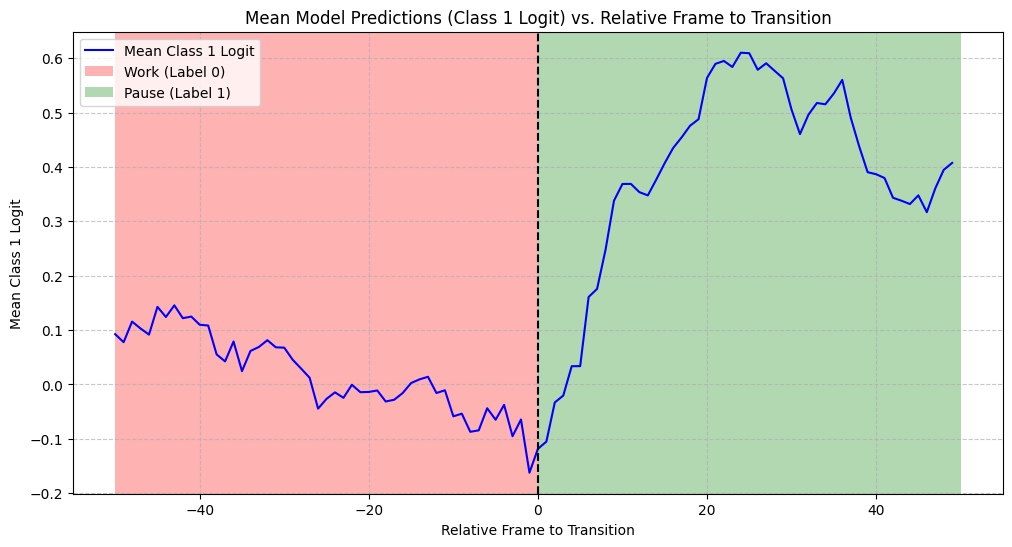

Mean logits statistics:
Mean logit (pause, -50 to 0): 0.0175
Mean logit (work, 0 to +50): 0.3935


In [ ]:
# Work to pause window and plot
import torch
import numpy as np

# Extract tensors from doppler_test_dataset
data_tensor = test_images # Shape: (N, 1, 112, 112)
labels_tensor = test_labels  # Shape: (N,)

# Parameters
min_state_length = 20
before_frames = 66
after_frames = 50
window_length = before_frames + after_frames

# Convert labels to NumPy for easier indexing
labels_np = labels_tensor.cpu().numpy()

# Find potential transition points: from 1 (pause) to 0 (work)
transitions = []
N = len(labels_np)
for i in range(1, N):
    if labels_np[i-1] == 0 and labels_np[i] == 1:
        # Check before: at least 50 consecutive 1's before i (i-51 to i-1 all 1)
        if i - min_state_length - 1 >= 0 and np.all(labels_np[i - min_state_length - 1:i - 1] == 0):
            # Check after: at least 50 consecutive 0's after i (i to i+49 all 0)
            if i + min_state_length <= N and np.all(labels_np[i:i + min_state_length] == 1):
                transitions.append(i)

print(f"Found {len(transitions)} valid transitions.")

# Create windows for each transition
windows = []
for trans_point in transitions:
    start_idx = trans_point - before_frames
    end_idx = trans_point + after_frames
    if start_idx >= 0 and end_idx <= N:
        window = data_tensor[start_idx:end_idx]
        windows.append(window)
    else:
        print(f"Skipping transition at {trans_point}: Insufficient frames around it.")

if windows:
    new_windows_tensor = torch.stack(windows)  # Shape: (K, window_length, 1, 112, 112)
    print(f"New transition windows tensor shape: {new_windows_tensor.shape}")
else:
    new_windows_tensor = torch.empty(0, window_length, 1, 112, 112)
    print("No valid transition windows found.")

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

model.eval()

# Assume model, device, new_window_tensor, WINDOW_SIZE, and other variables are defined
# new_window_tensor: [8, 72, 1, 112, 112] (8 transitions, each with 72 frames)

# Parameters
transition_point = 66 # Transition at frame 50 (0-based: frame 49 = last pause, 50 = first work)
relative_start = -50  # Relative to transition
relative_end = 50
relative_range = range(relative_start, relative_end)  # -50 to +50
num_transitions = new_windows_tensor.shape[0]  # 8

# Collect logits for class 1 across all transitions and relative positions
all_logits_class1 = np.zeros((num_transitions, len(relative_range)))  # [8, 101] for -50 to +50

with torch.no_grad():
    for trans_idx in range(num_transitions):
        transition_window = new_windows_tensor[trans_idx:trans_idx+1].to(device)  # [1, 72, 1, 112, 112]
        
        # Slide sub-windows of WINDOW_SIZE=16 over the 72-frame window
        # For each relative k, get sub-window ending at transition_point + k
        for k_idx, k in enumerate(relative_range):
            end_frame = transition_point + k
            start_frame = end_frame - window_size
            
            if start_frame < 0 or end_frame >= transition_window.shape[1]:
                print(f"Skipping invalid sub-window for trans {trans_idx}, relative {k}")
                print(f"  start_frame: {start_frame}, end_frame: {end_frame}")
                print(f"  window length: {transition_window.shape[1]}")
                continue
            
            sub_window = transition_window[:, start_frame:end_frame, :, :, :]  # [1, 16, 1, 112, 112]
            sub_window = sub_window.float()
            # Get model outputs
            outputs = model(pixel_values=sub_window).logits  # [1, 2]
            
            # Extract logit for class 1
            logit_class1 = outputs[0, 1].cpu().item()  # Raw score for class 1
            
            all_logits_class1[trans_idx, k_idx] = logit_class1

# Compute mean logits across transitions for each relative position
mean_logits_class1 = np.mean(all_logits_class1, axis=0)  # [101,]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the mean logits for class 1
plt.plot(relative_range, mean_logits_class1, color='blue', label='Mean Class 1 Logit', linewidth=1.5)

# Create background shading for labels
# Pause (-50 to 0): green, Work (0 to +50): red
plt.axvspan(relative_start, 0, facecolor='red', alpha=0.3, label='Work (Label 0)')
plt.axvspan(0, relative_end, facecolor='green', alpha=0.3, label='Pause (Label 1)')

# Customize the plot
plt.xlabel('Relative Frame to Transition')
plt.ylabel('Mean Class 1 Logit')
plt.title('Mean Model Predictions (Class 1 Logit) vs. Relative Frame to Transition')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(0, color='black', linestyle='--', label='Transition Point')

# Show the plot
plt.show()

# Print some statistics for verification
print("Mean logits statistics:")
print(f"Mean logit (pause, -50 to 0): {np.mean(mean_logits_class1[:51]):.4f}")
print(f"Mean logit (work, 0 to +50): {np.mean(mean_logits_class1[51:]):.4f}")

One good way to visualize the model's behavior is to see it's prediction across acquisitions on top of the actual labels. Here this function plots the model's logits across all the test datasets

Plotting for acquisition 0 which has transitions.


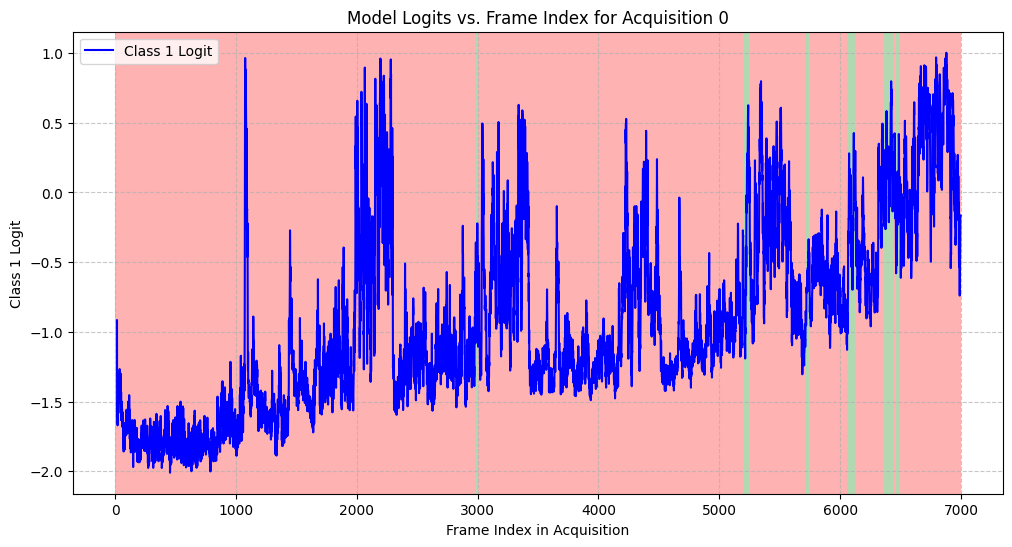

Plotting for acquisition 1 which has transitions.


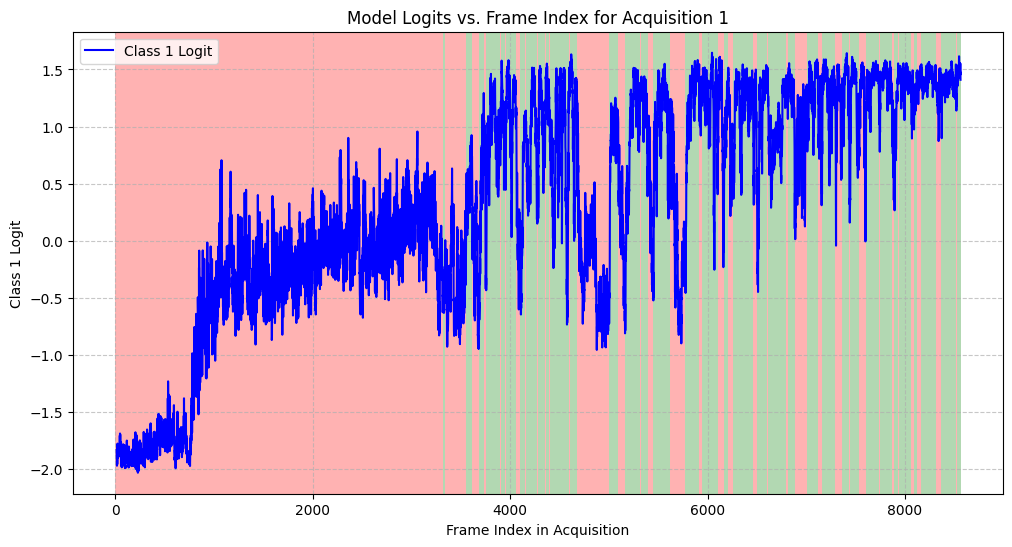

Plotting for acquisition 10 which has transitions.


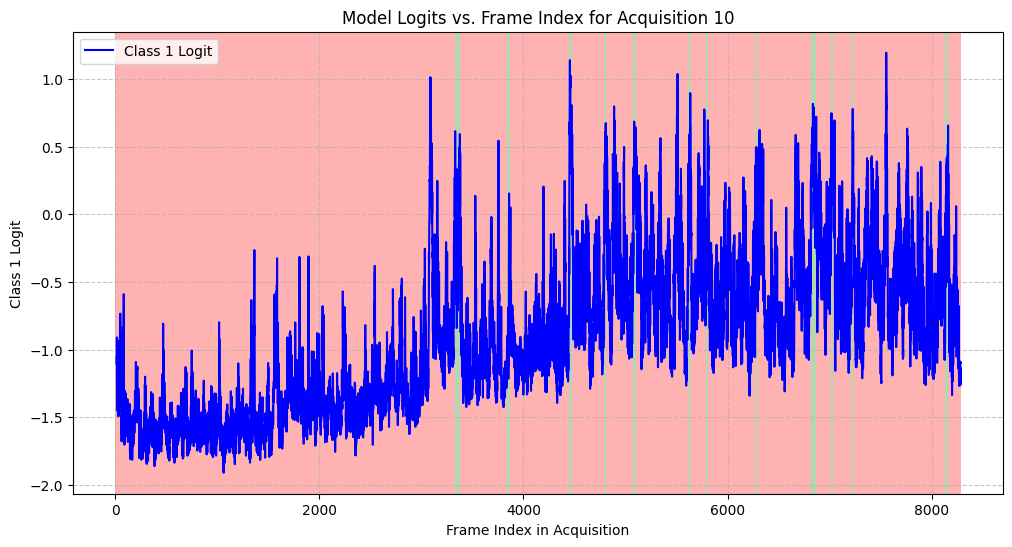

No acquisitions with transitions found; plotting the first one.


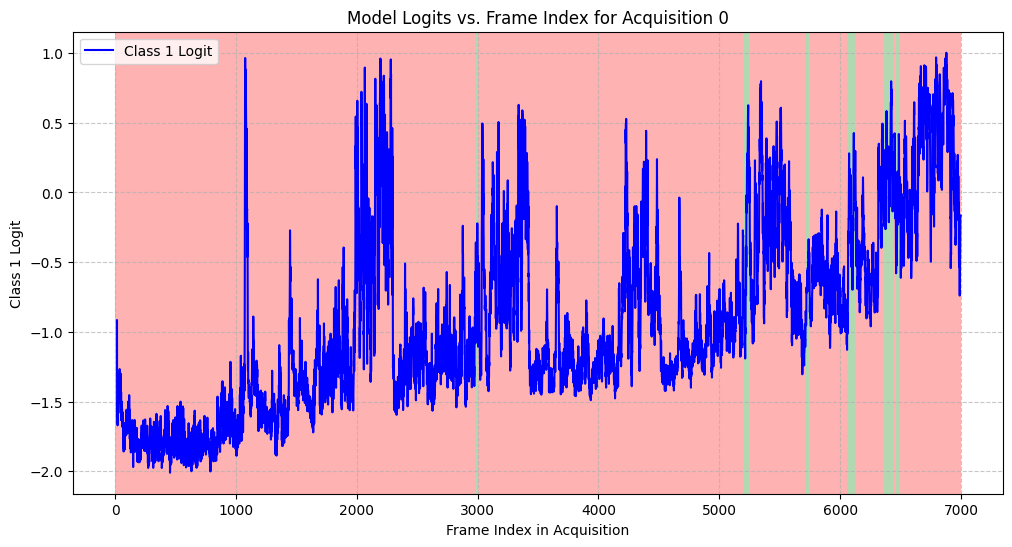

In [ ]:
# Logit across test dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assume model, device, test_images, test_labels, test_acqs are defined
# test_images: (N, 1, 112, 112)
# test_labels: (N,)
# test_acqs: (N,)  # Acquisition indices

model.eval()

# Parameters
window_size = 16  # Assuming based on previous skip pattern; adjust if different

# Function to plot for a specific acquisition
def plot_acquisition_logits(acq_id):
    # Get indices for this acquisition
    indices = torch.where(test_acqs == acq_id)[0].cpu().numpy()
    if len(indices) < window_size:
        print(f"Acquisition {acq_id} has too few frames ({len(indices)}), skipping.")
        return
    
    # Extract data and labels for this acq (assume indices are sorted/in order)
    acq_images = test_images[indices]  # (M, 1, 112, 112)
    acq_labels = test_labels[indices].cpu().numpy()  # (M,)
    M = len(indices)
    
    # Collect logits for class 1
    logits_class1 = []
    
    with torch.no_grad():
        for end_frame in range(window_size - 1, M):  # end_frame from 15 to M-1 for window_size=16
            start_frame = end_frame - window_size + 1
            sub_window = acq_images[start_frame:end_frame + 1].unsqueeze(0).to(device).float()  # (1, window_size, 1, 112, 112)
            outputs = model(pixel_values=sub_window).logits  # (1, 2)
            logit_class1 = outputs[0, 1].cpu().item()
            logits_class1.append(logit_class1)
    
    if not logits_class1:
        print(f"No valid windows for acquisition {acq_id}.")
        return
    
    # x positions for logits: align to end_frame position in original acq (from window_size-1 to M-1)
    x_logits = np.arange(window_size - 1, M)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot the logits for class 1
    plt.plot(x_logits, logits_class1, color='blue', label='Class 1 Logit', linewidth=1.5)
    
    # Add background shading for labels: find contiguous segments
    from itertools import groupby
    label_segments = [(key, sum(1 for _ in group)) for key, group in groupby(acq_labels)]
    current_start = 0
    for label, length in label_segments:
        color = 'green' if label == 1 else 'red'
        plt.axvspan(current_start, current_start + length, facecolor=color, alpha=0.3)
        current_start += length
    
    # Customize the plot
    plt.xlabel('Frame Index in Acquisition')
    plt.ylabel('Class 1 Logit')
    plt.title(f'Model Logits vs. Frame Index for Acquisition {acq_id}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.show()

# Example usage: find and plot for an acquisition with transitions
# First, find unique acqs
unique_acqs = torch.unique(test_acqs).cpu().numpy()

# To find one with transitions: check for label changes
def has_transition(acq_id):
    indices = torch.where(test_acqs == acq_id)[0].cpu().numpy()
    labels = test_labels[indices].cpu().numpy()
    return np.any(np.diff(labels) != 0)

# Find first acq with transition
for acq_id in unique_acqs:
    if has_transition(acq_id):
        print(f"Plotting for acquisition {acq_id} which has transitions.")
        plot_acquisition_logits(acq_id)

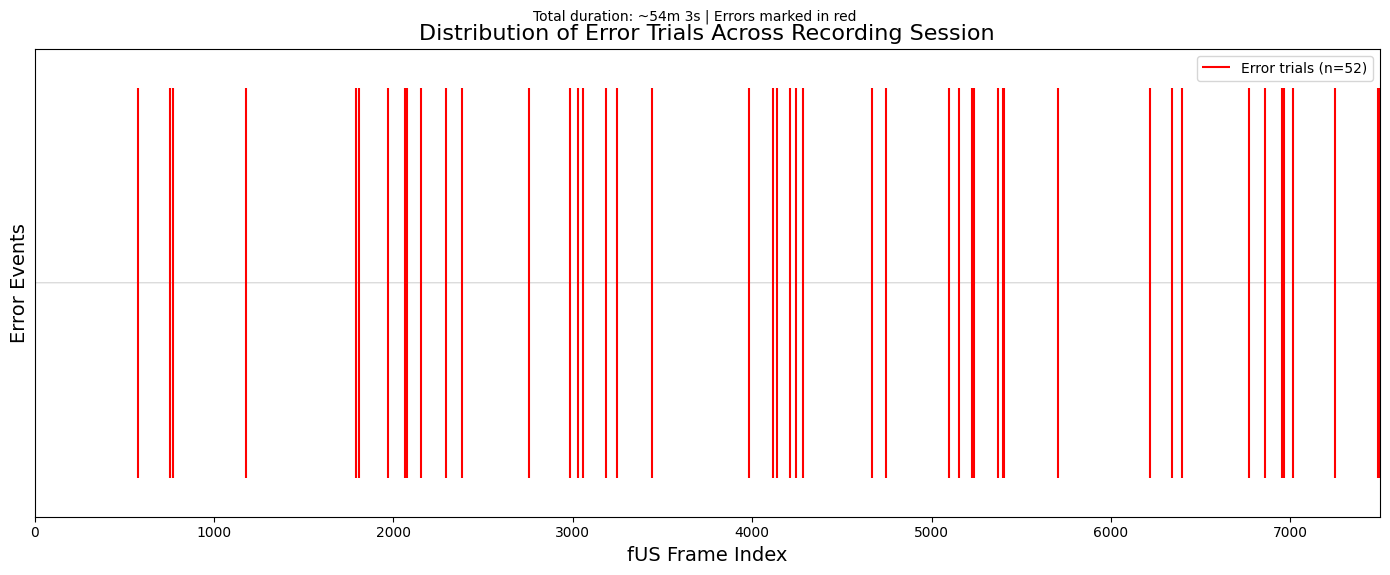


Found 52 error trials.
Error frames: [ 577  756  772 1178 1793 1809 1970 2065 2076 2154 2293 2384 2755 2986
 3031 3058 3184 3246 3442 3981 4116 4139 4208 4246 4283 4669 4743 5095
 5155 5226 5234 5372 5396 5405 5705 6217 6338 6393 6770 6859 6954 6962
 7013 7247 7490 7499 7499 7499 7499 7499 7499 7499]
First error at frame 577 (~487.8s)
Last error at frame 7499 (~3490.2s)


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume these are already defined in your workspace:
# - centers: np.array [n_frames] - timestamps in ms for each fUS frame
# - fus_df: pd.DataFrame - with columns 'saccade_time' (ms), 'outcome' ('success' or 'error')
#   (or use 'cue_time' if you prefer cue onsets instead of saccades)

acquisition = "Se01072020"

centers = np.load(rf"C:\Users\leo.sperber\FUSclass\modelV1\OOP_secundo\behavioral\{acquisition}_centers.npy")

fus_df = pd.read_csv(rf"C:\Users\leo.sperber\FUSclass\modelV1\OOP_secundo\behavioral\{acquisition}_trials.csv")

# Parameters
frame_numbers = np.arange(len(centers))  # X-axis: frame index (0 to n_frames-1)

# Find frame indices closest to error saccade_times
error_df = fus_df[fus_df['outcome'] == 'error']

if not error_df.empty:
    error_saccade_times = error_df['saccade_time'].values  # ms
    # Find the closest frame index for each error saccade
    error_frame_indices = []
    for t in error_saccade_times:
        idx = np.argmin(np.abs(centers - t))
        error_frame_indices.append(idx)
    
    error_frame_indices = np.array(error_frame_indices)
else:
    print("No error trials found in fus_df.")
    error_frame_indices = np.array([])

# Plot
plt.figure(figsize=(14, 6))
plt.plot(frame_numbers, np.zeros_like(frame_numbers), color='lightgray', linewidth=0.8)  # Baseline at y=0

if len(error_frame_indices) > 0:
    plt.vlines(error_frame_indices, ymin=-1, ymax=1, color='red', linewidth=1.5, label=f'Error trials (n={len(error_frame_indices)})')

plt.xlabel('fUS Frame Index', fontsize=14)
plt.ylabel('Error Events', fontsize=14)
plt.title('Distribution of Error Trials Across Recording Session', fontsize=16)
plt.xlim(0, len(centers) - 1)
plt.ylim(-1.2, 1.2)
plt.yticks([])  # Hide y-ticks since it's just event markers
plt.legend(loc='upper right')

# Optional: Add time in minutes/seconds on top axis
total_seconds = (centers[-1] - centers[0]) / 1000
minutes = int(total_seconds // 60)
seconds = int(total_seconds % 60)
plt.suptitle(f'Total duration: ~{minutes}m {seconds}s | Errors marked in red', fontsize=10, y=0.95)

plt.tight_layout()
plt.show()

# Print summary
if len(error_frame_indices) > 0:
    print(f"\nFound {len(error_frame_indices)} error trials.")
    print(f"Error frames: {error_frame_indices}")
    print(f"First error at frame {error_frame_indices[0]} (~{centers[error_frame_indices[0]]/1000:.1f}s)")
    print(f"Last error at frame {error_frame_indices[-1]} (~{centers[error_frame_indices[-1]]/1000:.1f}s)")
else:
    print("No errors to plot.")